# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, Decision Tree, and Ensemble

In [89]:
#1)Multiclass classification target distribution - aanpassen -done
#2)Threshhold meerdere waardes vullen en dat in Overleaf plaatsen ter discussie -fail
#3)ROC, AUC laten zien -done
#4) Zoek verder op de auteur naar vergelijkbaar werk -wip
#5) Use Arima as baseline -wip
#6) Try neural network -wip

In [90]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import csv
from pathlib import Path

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Machine learning - metrics
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# TensorFlow/Keras
from tensorflow.keras.callbacks import LearningRateScheduler

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

pd.set_option("display.max_rows", 25)

# 1. Data Loading

In [91]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [92]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


# 2. Data Cleaning & Transformation

## Filter to Selected Economic Indicators

In [93]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {
    # Core growth & external
    "NGDP_RPCH", "NGDPRPC", "PCPIPCH", "TX_RPCH", "TM_RPCH", "BCA_NGDPD",
    # Fiscal & debt aggregates
    "GGR_NGDP", "GGX_NGDP", "GGXWDN_NGDP", "GGXWDG_NGDP",
    # Savings & investment
    "NGSD_NGDP", "NID_NGDP",
    # Prices
    "PCPI", "LUR"
}

col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2744, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.542,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NID_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.987,16.668,15.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.172,99.536,96.586,94.587,58.568,56.051,53.294,52.315,50.485,48.312


## Data Reshaping: Wide to Long to Wide

In [94]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,345.977,NaN,6.943,NaN,21594.230,NaN,61.151,27.243,31.263,NaN,NaN,NaN
2003,Afghanistan,29.616,9.826,270.602,NaN,11.927,NaN,21766.381,8.692,59.718,30.102,42.413,35.663,36.222,49.541
2004,Afghanistan,37.216,12.676,244.967,NaN,15.069,NaN,21067.277,0.671,72.570,35.354,49.351,16.358,-0.427,-8.436
2005,Afghanistan,30.226,14.733,206.356,NaN,15.651,NaN,22731.779,11.830,67.274,37.048,54.566,10.569,55.010,41.968
2006,Afghanistan,20.844,18.946,22.985,NaN,18.262,NaN,22979.189,5.361,50.333,29.489,58.269,6.785,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,56.051,NaN,18.257,NaN,6.061,4.640,NaN,NaN,1204688.561,9.627,NaN,NaN
2027,Zimbabwe,2.927,19.117,53.294,NaN,18.231,NaN,6.150,3.630,NaN,NaN,1300690.916,7.969,NaN,NaN
2028,Zimbabwe,2.895,19.197,52.315,NaN,18.201,NaN,6.231,3.458,NaN,NaN,1404343.758,7.969,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [95]:
# --- Step 1: Ensure chronological order ---
df_pivot = df_pivot.sort_index()

# --- Step 2: Construct diagnostic flags (not stored in df) ---

# 1. GDP-based recession (two consecutive annual declines)
flag_gdp = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

# 2. Investment collapse (sharp drop in investment)
flag_invest = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# 3. Savings decline (household/national savings falling)
flag_savings = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# 4. Trade shock (both exports and imports contracting)
flag_trade = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

# 5. Inflation shock (stagflation: high inflation + negative growth)
flag_inflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

# 6. Debt crisis (gross debt rising sharply above 90% of GDP)
flag_debt = (
    (df_pivot["GGXWDG_NGDP"] > 90) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 10))
).astype(int)

# 7. Fiscal crisis (large and growing deficit)
flag_fiscal = (
    (df_pivot.groupby("Country")["GGR_NGDP"].transform(lambda x: x) < 
     df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x) - 5) &  # Deficit > 5% GDP
    (df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x.diff()) > 2)  # Rising spending
).astype(int)

# 8. Current account crisis (large deficit deteriorating)
flag_current_account = (
    (df_pivot["BCA_NGDPD"] < -5) &  # Deficit > 5% of GDP
    (df_pivot.groupby("Country")["BCA_NGDPD"].transform(lambda x: x.diff() < -2))  # Worsening
).astype(int)

# 9. Real GDP growth collapse (severe contraction)
flag_growth_collapse = (
    df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < -3)  # Growth < -3%
).astype(int)

# 10. Deflation risk (falling prices with economic weakness)
flag_deflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x < 0)) &  # Negative inflation
    (df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < 1))  # Weak growth
).astype(int)

# 11. Credit crunch (investment falling while debt rising)
flag_credit_crunch = (
    (df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -1)) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 5))
).astype(int)

# 12. External shock (exports collapsing while imports stable/rising)
flag_external_shock = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < -5)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x > -2))
).astype(int)

# --- Step 3: Combine signals into a single severity score ---
local_signal_count = (
    flag_gdp + 
    flag_invest + 
    flag_savings + 
    flag_trade + 
    flag_inflation +
    flag_debt +
    flag_fiscal +
    flag_current_account +
    flag_growth_collapse +
    flag_deflation +
    flag_credit_crunch +
    flag_external_shock
)

# --- Step 4: Multiclass recession risk label ---
def classify_risk(local_count):
    """
    Same thresholds as original:
    - 3+ signals: High risk
    - 2 signals: Moderate risk  
    - 1 signal: Mild risk
    - 0 signals: No risk
    """
    if local_count >= 3:
        return 3  # High risk
    if local_count == 2:
        return 2  # Moderate risk
    if local_count == 1:
        return 1  # Mild risk
    return 0      # No risk

df_pivot["RecessionRisk"] = [
    classify_risk(l) for l in local_signal_count
]

# Store signal count
df_pivot["SignalCount"] = local_signal_count

# --- Step 5: Fill NaN with mean instead of dropping ---
# Fill numeric columns with their mean
numeric_cols = df_pivot.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df_pivot[col] = df_pivot[col].fillna(df_pivot[col].mean())

# Fill non-numeric columns with forward fill or mode
non_numeric_cols = df_pivot.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    if col == 'Country':
        continue  # Don't fill Country column
    df_pivot[col] = df_pivot[col].fillna(method='ffill').fillna(method='bfill')

df_pivot = df_pivot.sort_index(ascending=True)

# --- Step 6: Show distribution ---
print("=" * 70)
print("RECESSION RISK CLASSIFICATION SUMMARY (12 Indicators)")
print("=" * 70)

print("\nRecessionRisk class distribution:")
print(df_pivot["RecessionRisk"].value_counts().sort_index())
print(f"\nTotal samples: {len(df_pivot)}")

# Show average signals per risk class
print("\n" + "=" * 70)
print("AVERAGE SIGNALS TRIGGERED PER RISK CLASS:")
print("=" * 70)

signal_summary = df_pivot.groupby('RecessionRisk')['SignalCount'].agg(['mean', 'min', 'max', 'count'])
print(signal_summary)

# Show which signals are most common
print("\n" + "=" * 70)
print("INDIVIDUAL SIGNAL FREQUENCIES:")
print("=" * 70)

# Recalculate flags for cleaned data
flag_gdp_clean = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

flag_invest_clean = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

flag_savings_clean = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

flag_trade_clean = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

flag_inflation_clean = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

flag_debt_clean = (
    (df_pivot["GGXWDG_NGDP"] > 90) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 10))
).astype(int)

flag_fiscal_clean = (
    (df_pivot.groupby("Country")["GGR_NGDP"].transform(lambda x: x) < 
     df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x) - 5) &
    (df_pivot.groupby("Country")["GGX_NGDP"].transform(lambda x: x.diff()) > 2)
).astype(int)

flag_current_account_clean = (
    (df_pivot["BCA_NGDPD"] < -5) &
    (df_pivot.groupby("Country")["BCA_NGDPD"].transform(lambda x: x.diff() < -2))
).astype(int)

flag_growth_collapse_clean = (
    df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < -3)
).astype(int)

flag_deflation_clean = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["NGDP_RPCH"].transform(lambda x: x < 1))
).astype(int)

flag_credit_crunch_clean = (
    (df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -1)) &
    (df_pivot.groupby("Country")["GGXWDG_NGDP"].transform(lambda x: x.diff() > 5))
).astype(int)

flag_external_shock_clean = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < -5)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x > -2))
).astype(int)

signal_names = [
    'GDP Decline', 'Investment Collapse', 'Savings Decline', 'Trade Shock',
    'Inflation Shock', 'Debt Crisis', 'Fiscal Crisis', 'Current Account Crisis',
    'Growth Collapse', 'Deflation Risk', 'Credit Crunch', 'External Shock'
]

signals_clean = [
    flag_gdp_clean, flag_invest_clean, flag_savings_clean, flag_trade_clean, 
    flag_inflation_clean, flag_debt_clean, flag_fiscal_clean, flag_current_account_clean,
    flag_growth_collapse_clean, flag_deflation_clean, flag_credit_crunch_clean, 
    flag_external_shock_clean
]

for name, signal in zip(signal_names, signals_clean):
    count = signal.sum()
    pct = (count / len(df_pivot)) * 100
    print(f"{name:<25} {count:>5} ({pct:>5.2f}%)")

print("\n" + "=" * 70)

# Remove temporary column
df_pivot = df_pivot.drop(columns=['SignalCount'])

# --- Output: dataframe with multiclass label ---
df_pivot

C:\Users\ningw\AppData\Local\Temp\ipykernel_38552\673714582.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
C:\Users\ningw\AppData\Local\Temp\ipykernel_38552\673714582.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
C:\Users\ningw\AppData\Local\Temp\ipykernel_38552\673714582.py:31: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in a

RECESSION RISK CLASSIFICATION SUMMARY (12 Indicators)

RecessionRisk class distribution:
RecessionRisk
0    4702
1    2080
2    1206
3    1221
Name: count, dtype: int64

Total samples: 9209

AVERAGE SIGNALS TRIGGERED PER RISK CLASS:
                   mean  min  max  count
RecessionRisk                           
0              0.000000    0    0   4702
1              1.000000    1    1   2080
2              2.000000    2    2   1206
3              3.876331    3    9   1221

INDIVIDUAL SIGNAL FREQUENCIES:
GDP Decline                1055 (11.46%)
Investment Collapse        1502 (16.31%)
Savings Decline            1573 (17.08%)
Trade Shock                1137 (12.35%)
Inflation Shock             714 ( 7.75%)
Debt Crisis                 205 ( 2.23%)
Fiscal Crisis               515 ( 5.59%)
Current Account Crisis     1005 (10.91%)
Growth Collapse             655 ( 7.11%)
Deflation Risk              173 ( 1.88%)
Credit Crunch               361 ( 3.92%)
External Shock              518 ( 5.62

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
1980,Philippines,-5.135,28.885018,56.173166,43.869771,31.637437,8.615541,92589.626,5.149,17.114000,23.435000,6.258000e+00,18.201000,3.723000,15.287000,0
1980,Algeria,0.526,28.885018,56.173166,43.869771,31.637437,15.789000,150958.885,-5.400,28.040000,36.058000,8.975000e+00,9.668000,5.047000,-14.588000,2
1980,Albania,0.053,28.885018,56.173166,43.869771,31.637437,5.028000,238341.384,2.684,26.802000,5.349000,1.107572e+11,37.137608,0.000000,0.000000,0
1980,Solomon_Islands,-3.109,24.319000,56.173166,43.869771,20.897000,8.615541,17176.953,-2.663,7.122000,3.650000,4.221000e+00,8.250000,14.100000,3.021000,0
1980,Cyprus,-11.164,28.885018,56.173166,43.869771,31.637437,8.615541,9448.317,5.920,28.651000,49.258000,3.216300e+01,13.518000,4.353000,9.317000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Tajikistan,-2.240,27.489000,29.198000,43.869771,29.750000,8.615541,51.568,4.500,20.603000,22.843000,2.922129e+03,6.500000,0.000000,0.000000,0
2030,Tanzania,-2.477,16.460000,40.381000,43.869771,19.135000,8.615541,2904355.925,6.196,39.159000,41.636000,5.395380e+02,4.001000,8.475000,3.836000,0
2030,The_Gambia,-0.561,20.622000,44.413000,43.869771,20.980000,8.615541,31800.257,5.002,20.780000,21.340000,1.210157e+03,5.000000,0.647000,7.557000,0


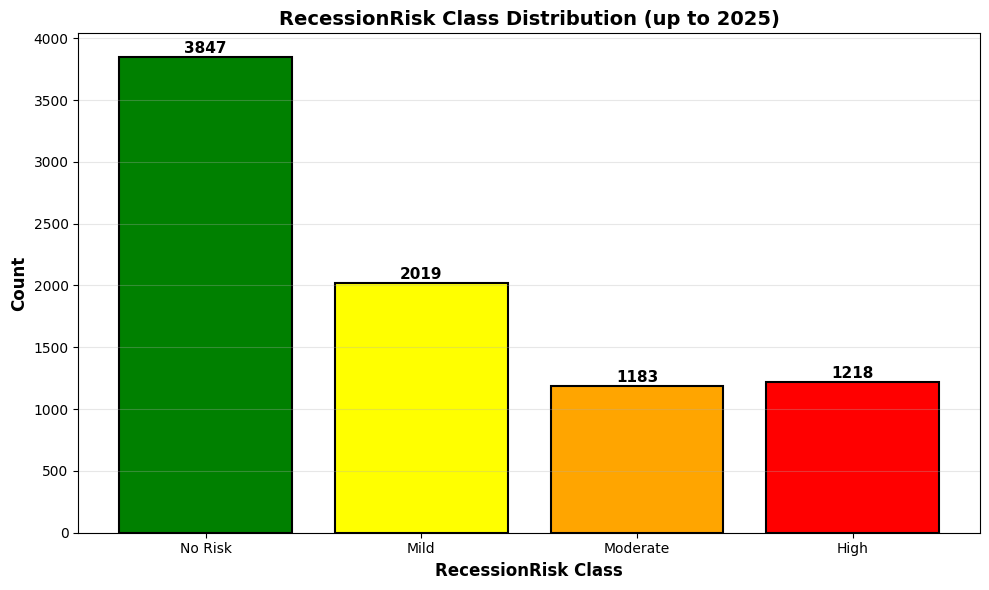

Total samples (up to 2025): 8267


In [96]:
# RecessionRisk Class Distribution - Compact Plot (up to 2025)
df_until_2025 = df_pivot[df_pivot.index <= 2025]
risk_counts = df_until_2025["RecessionRisk"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
colors = ['green', 'yellow', 'orange', 'red']
plt.bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('RecessionRisk Class Distribution (up to 2025)', fontsize=14, fontweight='bold')
plt.xticks([0, 1, 2, 3], ['No Risk', 'Mild', 'Moderate', 'High'])
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for cls, count in risk_counts.items():
    plt.text(cls, count + 10, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples (up to 2025): {len(df_until_2025)}")

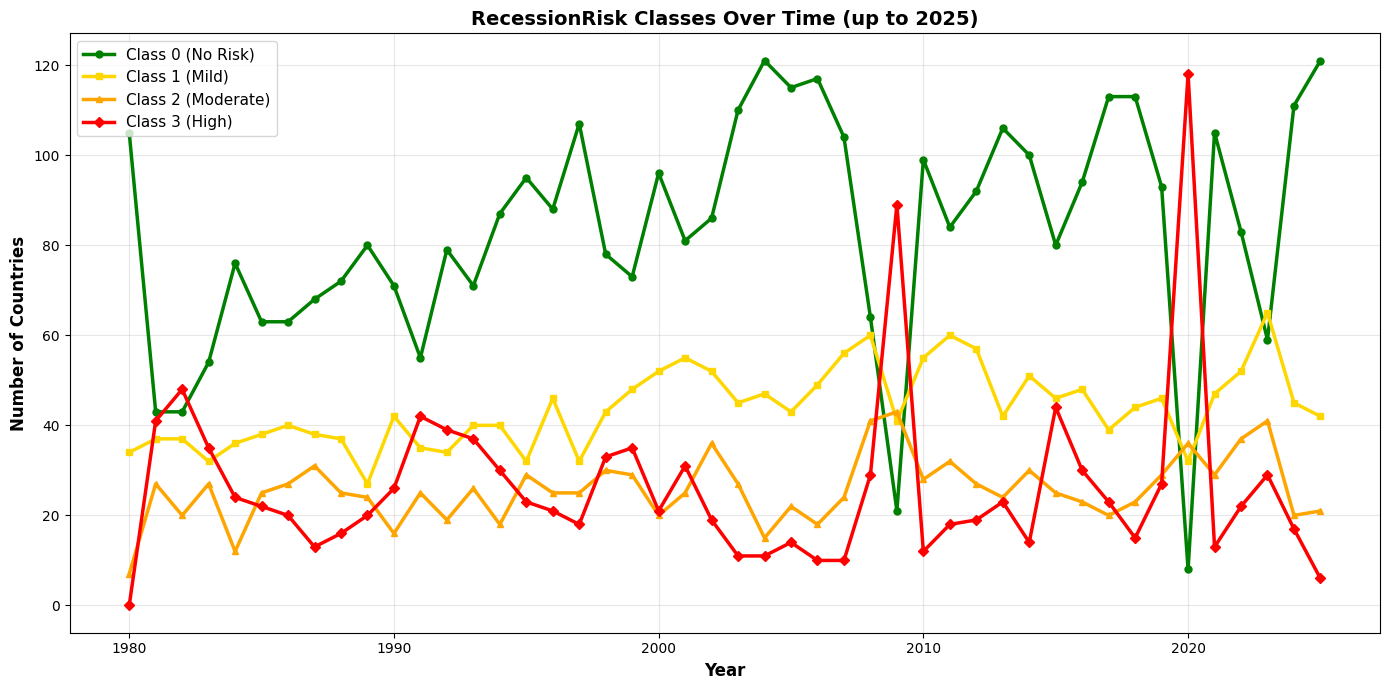

In [97]:
# All RecessionRisk Classes by Year - Line Graph (up to 2025)
# Calculate counts for each class by year
df0 = df_until_2025[df_until_2025["RecessionRisk"] == 0].copy()
df1 = df_until_2025[df_until_2025["RecessionRisk"] == 1].copy()
df2 = df_until_2025[df_until_2025["RecessionRisk"] == 2].copy()
df3 = df_until_2025[df_until_2025["RecessionRisk"] == 3].copy()

class0_by_year = df0.groupby(df0.index).size()
class1_by_year = df1.groupby(df1.index).size()
class2_by_year = df2.groupby(df2.index).size()
class3_by_year = df3.groupby(df3.index).size()

# Get all years (up to 2025)
all_years = sorted(df_until_2025.index.unique())

# Reindex to include all years (fill missing with 0)
class0_by_year = class0_by_year.reindex(all_years, fill_value=0)
class1_by_year = class1_by_year.reindex(all_years, fill_value=0)
class2_by_year = class2_by_year.reindex(all_years, fill_value=0)
class3_by_year = class3_by_year.reindex(all_years, fill_value=0)

plt.figure(figsize=(14, 7))
plt.plot(all_years, class0_by_year.values, color='green', linewidth=2.5, marker='o', label='Class 0 (No Risk)', markersize=5)
plt.plot(all_years, class1_by_year.values, color='gold', linewidth=2.5, marker='s', label='Class 1 (Mild)', markersize=5)
plt.plot(all_years, class2_by_year.values, color='orange', linewidth=2.5, marker='^', label='Class 2 (Moderate)', markersize=5)
plt.plot(all_years, class3_by_year.values, color='red', linewidth=2.5, marker='D', label='Class 3 (High)', markersize=5)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Countries', fontsize=12, fontweight='bold')
plt.title('RecessionRisk Classes Over Time (up to 2025)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cutting Out Data that leads to biasness & Review Remaining Countries

In [98]:
df_filtered = df_pivot.loc[(df_pivot.index >= 2000) & (df_pivot.index <= 2025)]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
2000,Togo,-6.956,8.456000,56.173166,43.869771,11.901000,8.615541,4.024883e+05,-0.970,3.674000,10.630000,7.139700e+01,1.567,-10.349000,-10.852000,2
2000,Zimbabwe,2.838,28.885018,56.173166,43.869771,31.637437,8.615541,7.322000e+00,-4.231,20.686686,24.154875,1.000000e+02,4.475,5.351302,5.552211,2
2000,Indonesia,4.452,13.433000,87.437000,43.869771,15.303000,6.080000,1.967490e+07,4.979,24.905000,25.087000,2.709000e+01,3.688,25.495000,17.851000,0
2000,France,1.103,51.306000,59.721000,50.654000,52.622000,9.175000,3.219452e+04,4.364,22.961000,21.858000,7.822600e+01,1.815,15.609000,13.266000,0
2000,Chad,-10.479,9.355000,52.407000,43.869771,14.036000,8.615541,3.292346e+05,-0.880,10.265000,20.744000,6.534100e+01,3.823,3.110000,5.394000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,Tonga,-6.947,41.769000,44.128000,43.869771,49.670000,8.615541,1.099938e+04,2.725,20.686686,24.154875,1.317410e+02,3.570,5.351302,5.552211,1
2025,Venezuela,-0.067,28.885018,56.173166,43.869771,31.637437,8.615541,2.238718e+06,-4.000,20.686686,24.154875,7.632536e+11,180.001,-15.518000,-7.966000,2
2025,Cyprus,-7.265,44.195000,60.282000,25.732000,40.357000,4.773000,3.036760e+04,2.545,13.390000,20.655000,1.197320e+02,2.272,4.660000,4.186000,0


In [99]:
df_filtered["Country"].unique()

array(['Togo', 'Zimbabwe', 'Indonesia', 'France', 'Chad', 'Slovenia',
       'India', 'Vietnam', 'Germany', 'Sri_Lanka', 'Libya', 'Algeria',
       'Angola', 'Liberia', 'Belize', 'Mozambique', 'Dominican_Republic',
       'Benin', 'Ecuador', 'Tanzania', 'Kenya',
       'St._Vincent_and_the_Grenadines', 'Mauritania', 'Oman', 'Armenia',
       'Fiji', 'Lao_P.D.R.', 'Ethiopia', 'Greece', 'United_Arab_Emirates',
       'Bhutan', 'Senegal', 'Colombia', 'Mali', 'Netherlands', 'China',
       'Belgium', 'Seychelles', 'Tonga', 'West_Bank_and_Gaza',
       'Singapore', 'Nepal', 'Pakistan', 'Madagascar', 'Burundi',
       'Türkiye', 'Cabo_Verde', 'Hungary', 'Myanmar', 'Kazakhstan',
       'Guyana', 'Bolivia', 'Belarus', 'Egypt', 'Guinea_Bissau', 'Aruba',
       'The_Gambia', 'St._Kitts_and_Nevis', 'Eswatini', 'Ukraine',
       'Tajikistan', 'Bosnia_and_Herzegovina', 'Argentina', 'Finland',
       'Lithuania', 'Latvia', 'Papua_New_Guinea', 'Dominica',
       'United_States', 'South_Africa', 'Ugan

# 4. Exploratory Data Analysis

## Correlation Heatmap

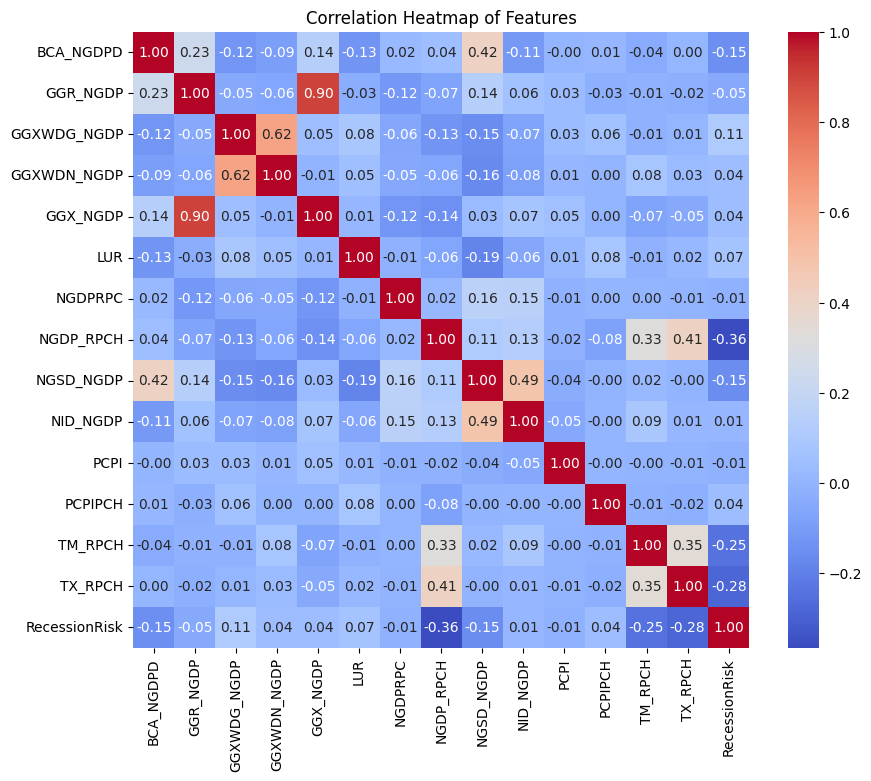

In [100]:
corr = df_filtered.drop(columns=["Country"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

## Prepare Features and Target

In [101]:
X = df_filtered.drop(columns=["RecessionRisk", "Country"])
y = df_filtered["RecessionRisk"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [102]:
# ============================================================
#             TRAIN ALL MODELS (MULTICLASS) - IMPROVED
# ============================================================
def train_all_models(X_train, y_train, X_test, y_test, model_params=None, use_xgb=False):
    """
    Enhanced model training with:
    - Improved hyperparameters
    - Better class weight handling
    - Optimized ensemble strategy
    """
    if model_params is None:
        model_params = {
            'logit': {
                'C': 0.5,  # Increased from 0.2 for better fit
                'penalty': 'l2',
                'solver': 'saga',  # Better for multiclass
                'max_iter': 10000,  # Increased iterations
                'random_state': 42,
                'class_weight': 'balanced'  # Handle imbalance
            },
            'rf': {
                'n_estimators': 300,  # Increased trees
                'max_depth': 6,  # Slightly deeper
                'min_samples_leaf': 15,  # Reduced for more flexibility
                'min_samples_split': 30,
                'max_features': 'sqrt',  # Better than fixed 0.3
                'random_state': 42,
                'class_weight': 'balanced',
                'n_jobs': -1
            },
            'gb': {
                'n_estimators': 300,  # More estimators
                'learning_rate': 0.05,  # Slightly increased
                'max_depth': 3,  # Deeper trees
                'min_samples_leaf': 15,
                'subsample': 0.7,  # Increased
                'max_features': 'sqrt',
                'random_state': 42
            },
            'dt': {
                'max_depth': 4,  # Slightly deeper
                'min_samples_leaf': 25,
                'min_samples_split': 50,
                'random_state': 42,
                'class_weight': 'balanced'
            },
            'svm': {
                'C': 2.0,  # Increased regularization
                'kernel': 'rbf',
                'gamma': 'scale',
                'probability': True,
                'random_state': 42,
                'decision_function_shape': 'ovr',
                'class_weight': 'balanced'
            },
            'xgb': {
                'n_estimators': 300,
                'learning_rate': 0.07,
                'max_depth': 3,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.3,
                'reg_lambda': 1.5,
                'random_state': 42,
                'objective': 'multi:softprob',
                'num_class': len(np.unique(y_train)),
                'tree_method': 'hist'
            }
        }

    # ----------------- Train models with improved SMOTE strategy -----------------
    # Use stratified SMOTE with k_neighbors adjusted for minority class
    smote_kwargs = {'random_state': 42, 'k_neighbors': 3}  # Reduced k for small classes
    
    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(**smote_kwargs)),
        ("logit", LogisticRegression(**model_params['logit']))
    ]).fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ]).fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ]).fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(**smote_kwargs)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ]).fit(X_train, y_train)

    svm = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(**smote_kwargs)),
        ("svm", SVC(**model_params['svm']))
    ]).fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
        "SVM": svm,
    }

    if use_xgb:
        xgb = ImbPipeline([
            ("smote", SMOTE(**smote_kwargs)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ]).fit(X_train, y_train)
        models["XGBoost"] = xgb

    # ----------------- Improved Ensemble with weighted voting -----------------
    # Use best performing models with weights
    ensemble_estimators = [
        ("rf", rf.named_steps["rf"]),  # RF typically performs well
        ("gb", gb.named_steps["gb"]),  # GB is strong
        ("svm", svm.named_steps["svm"]),  # SVM adds diversity
        ("logit", logit.named_steps["logit"])  # Linear baseline
    ]
    
    # Weight models based on typical performance (can tune after first run)
    ensemble_weights = [2, 2, 1, 1]  # Give more weight to tree models
    
    if use_xgb:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))
        ensemble_weights.append(2)

    ensemble = VotingClassifier(
        estimators=ensemble_estimators, 
        voting="soft",
        weights=ensemble_weights
    )
    ensemble.fit(X_train, y_train)
    models["Ensemble (Weighted)"] = ensemble

    # ----------------- Metrics with additional evaluation -----------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        y_pred_train = m.predict(X_train)
        y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision (macro)": precision_score(y_test, y_pred_test, average="macro", zero_division=0),
            "Recall (macro)": recall_score(y_test, y_pred_test, average="macro", zero_division=0),
            "F1 (macro)": f1_score(y_test, y_pred_test, average="macro", zero_division=0),
            # Add weighted F1 for imbalanced datasets
            "F1 (weighted)": f1_score(y_test, y_pred_test, average="weighted", zero_division=0)
        }

        confusion_mats[name] = confusion_matrix(y_test, y_pred_test)

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats


# ============================================================
#             FEATURE IMPORTANCE (MULTICLASS)
# ============================================================
def plot_feature_importance(models, feature_names, title_prefix="", top_n=15):
    """
    Display feature importance with improved visualization.
    top_n: Show only top N most important features
    """
    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef_matrix = logit.named_steps['logit'].coef_
    coef_mean_abs = np.mean(np.abs(coef_matrix), axis=0)

    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": coef_mean_abs
    }).sort_values("Importance", ascending=False).head(top_n)

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance", ascending=False).head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Sort in ascending order for better visualization
    logit_sorted = logit_importance.sort_values("Importance")
    rf_sorted = rf_importance.sort_values("Importance")
    gb_sorted = gb_importance.sort_values("Importance")
    dt_sorted = dt_importance.sort_values("Importance")

    axes[0, 0].barh(logit_sorted["Feature"], logit_sorted["Importance"], color='steelblue')
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression (Top {top_n})", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel("Mean |Coefficient|")

    axes[0, 1].barh(rf_sorted["Feature"], rf_sorted["Importance"], color='forestgreen')
    axes[0, 1].set_title(f"{title_prefix}Random Forest (Top {top_n})", fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel("Feature Importance")

    axes[1, 0].barh(gb_sorted["Feature"], gb_sorted["Importance"], color='darkorange')
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting (Top {top_n})", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel("Feature Importance")

    axes[1, 1].barh(dt_sorted["Feature"], dt_sorted["Importance"], color='crimson')
    axes[1, 1].set_title(f"{title_prefix}Decision Tree (Top {top_n})", fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()


# ============================================================
#             CONFUSION MATRIX DISPLAY (MULTICLASS)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df):
    """
    Display confusion matrices with percentage annotations for better interpretability.
    """
    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)

        acc = results_df.loc[name, "Test Accuracy"]
        prec = results_df.loc[name, "Precision (macro)"]
        rec = results_df.loc[name, "Recall (macro)"]
        f1 = results_df.loc[name, "F1 (macro)"]

        ax.set_title(
            f"{name}\nAcc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1={f1:.3f}",
            fontsize=10,
            fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

# ============================================================
#             ROC CURVES + MACRO AUC (MULTICLASS)
# ============================================================
def show_roc_curves(models, X_test, y_test):
    """
    Display ROC curves and macro AUC for all models.
    Works for multiclass classification.
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    classes = sorted(np.unique(y_test))

    for ax, (name, model) in zip(axes, models.items()):

        if not hasattr(model, "predict_proba"):
            ax.set_title(f"{name}\n(No predict_proba)")
            ax.axis("off")
            continue

        # Predict probabilities
        y_proba = model.predict_proba(X_test)

        aucs = []
        for c in classes:
            y_true_bin = (y_test == c).astype(int)
            y_score = y_proba[:, c]

            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)

            ax.plot(fpr, tpr, label=f"Class {c} (AUC={auc_val:.2f})", linewidth=2)

        macro_auc = np.mean(aucs)

        ax.plot([0, 1], [0, 1], "k--", alpha=0.5, linewidth=1.5, label='Random')
        ax.set_title(f"{name}\nMacro AUC={macro_auc:.3f}", fontsize=11, fontweight='bold')
        ax.set_xlabel("False Positive Rate", fontsize=10)
        ax.set_ylabel("True Positive Rate", fontsize=10)
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [103]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Training the model 

                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.463027       0.418651           0.363573   
Random Forest              0.642680       0.559524           0.484814   
Gradient Boosting          0.723077       0.510913           0.446196   
Decision Tree              0.539950       0.531746           0.490312   
SVM                        0.664268       0.497024           0.402305   
Ensemble (Weighted)        0.752854       0.595238           0.497734   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.412345    0.376285       0.416164  
Random Forest              0.518550    0.489785       0.545377  
Gradient Boosting          0.485603    0.459277       0.513554  
Decision Tree              0.502426    0.484311       0.533012  
SVM                        0.425931    0.409164       0.485281  
Ensemble (Weighted)        0.484296    0.466139       0.539188  


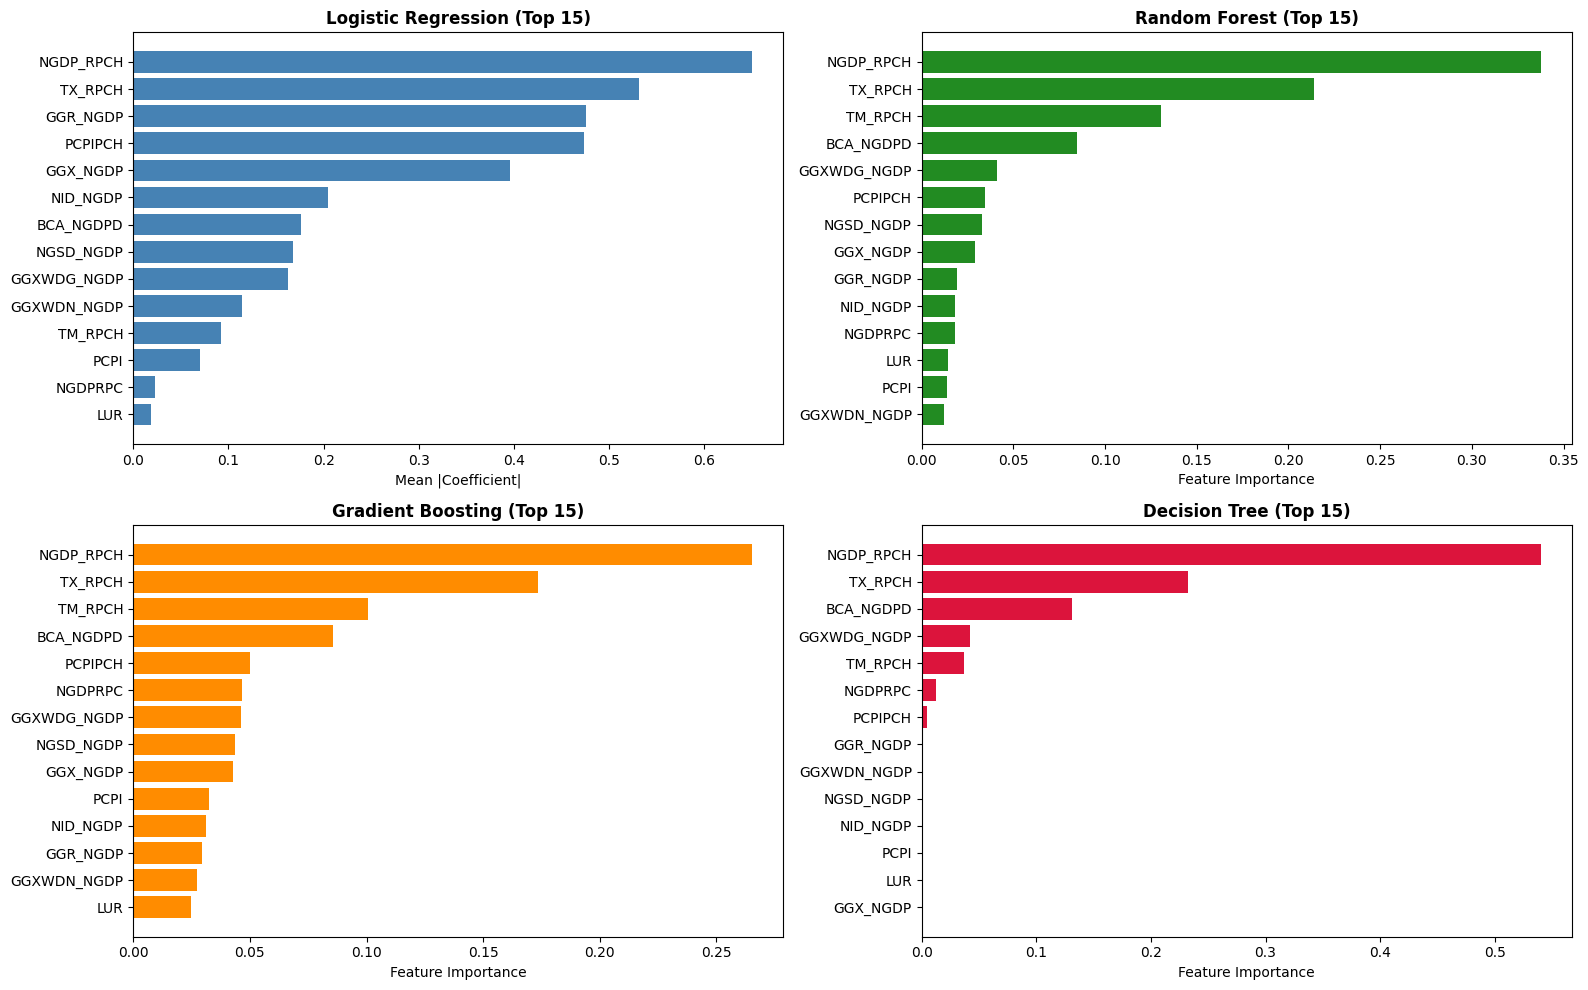

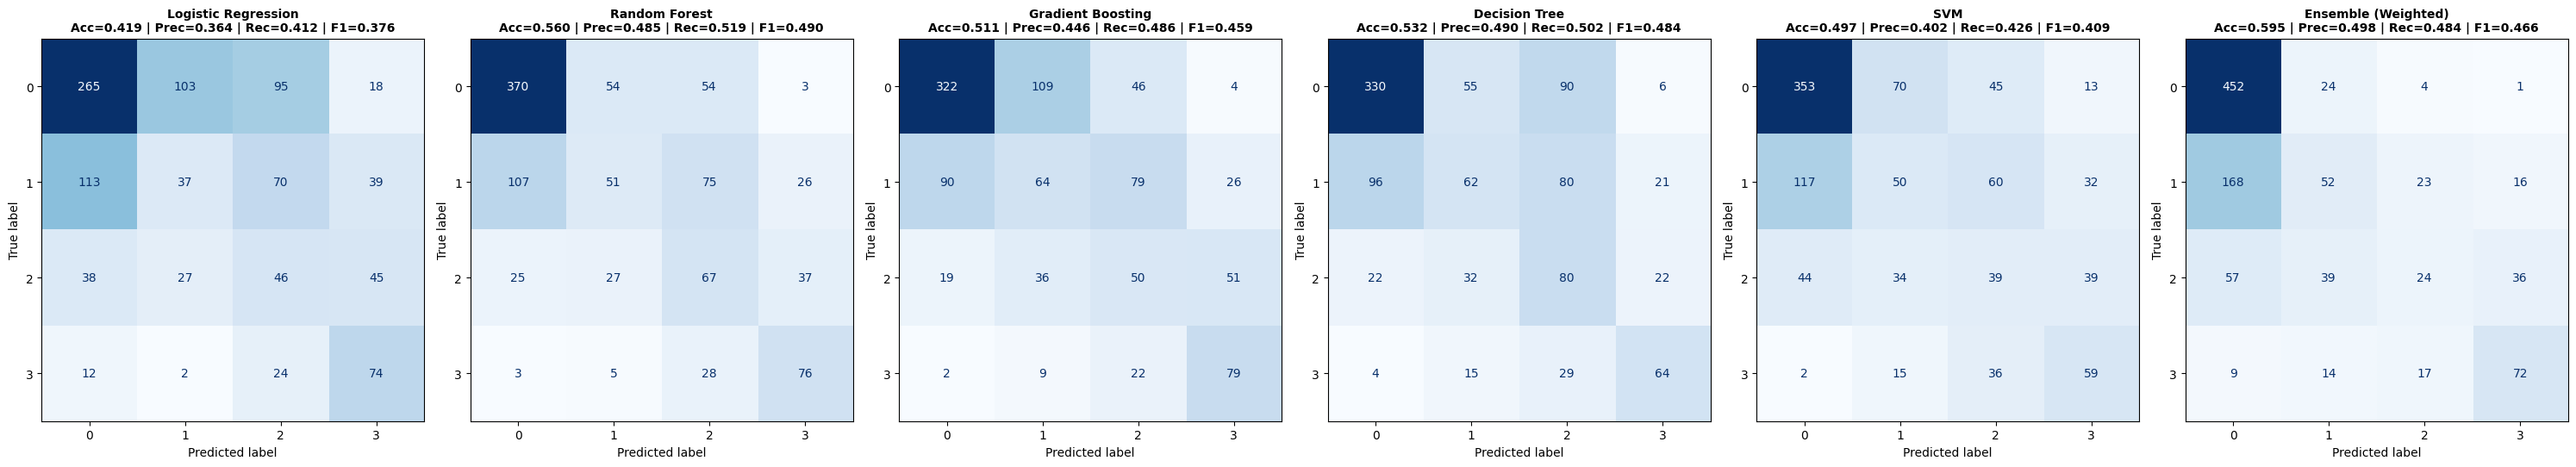

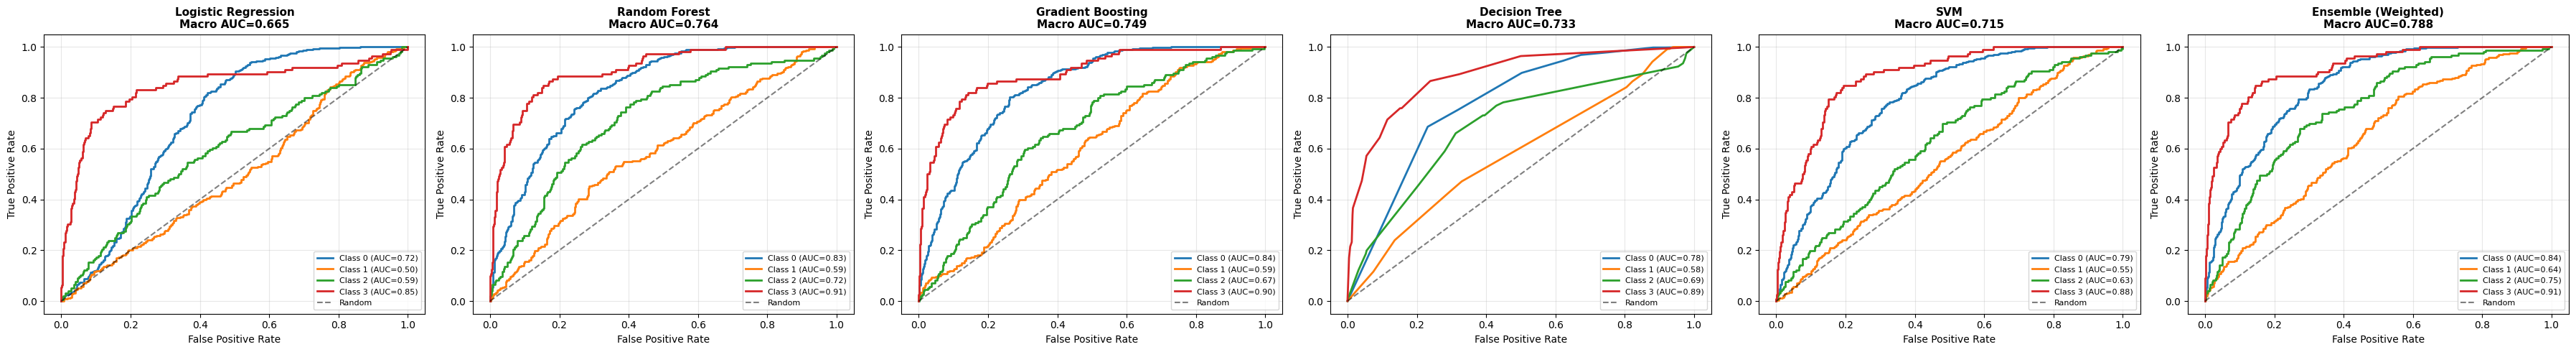

In [104]:
models, summary_df, confusion_mats = train_all_models(X_train, y_train, X_test, y_test)

print(summary_df)
plot_feature_importance(models, X_train.columns.tolist())
# Show confusion matrices with metrics underneath
show_confusion_matrices(confusion_mats, summary_df)
show_roc_curves(models, X_test, y_test)


### Reduced Global Set

In [ ]:
#reduced variables set
selected_features = ['TM_RPCH', 'NGDP_RPCH', 'TX_RPCH', 'BCA_NGDPD', 'PCPICH', 'NGDPRPC']

                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.404467       0.379960           0.377130   
Random Forest              0.631266       0.560516           0.496586   
Gradient Boosting          0.694541       0.544643           0.471403   
Decision Tree              0.566005       0.539683           0.489150   
SVM                        0.620099       0.545635           0.478913   
Ensemble (Weighted)        0.707444       0.589286           0.513394   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.402644    0.377237       0.390995  
Random Forest              0.493325    0.493140       0.555514  
Gradient Boosting          0.470165    0.470718       0.542388  
Decision Tree              0.480891    0.479838       0.538140  
SVM                        0.470416    0.472600       0.534632  
Ensemble (Weighted)        0.482878    0.479584       0.552392  


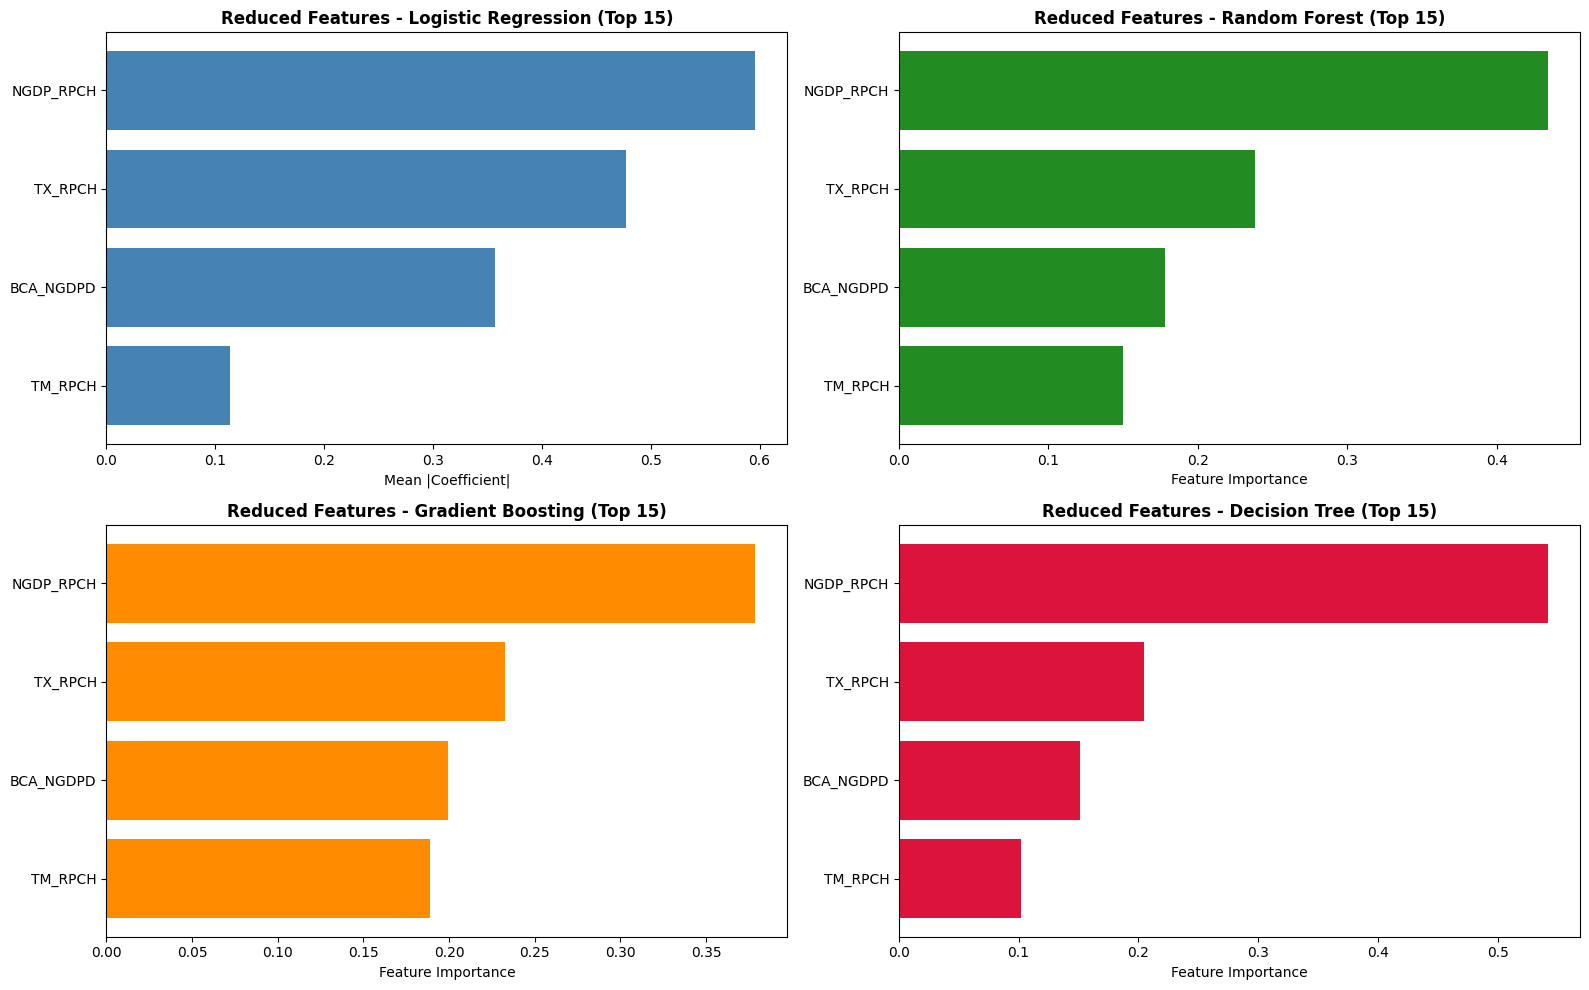

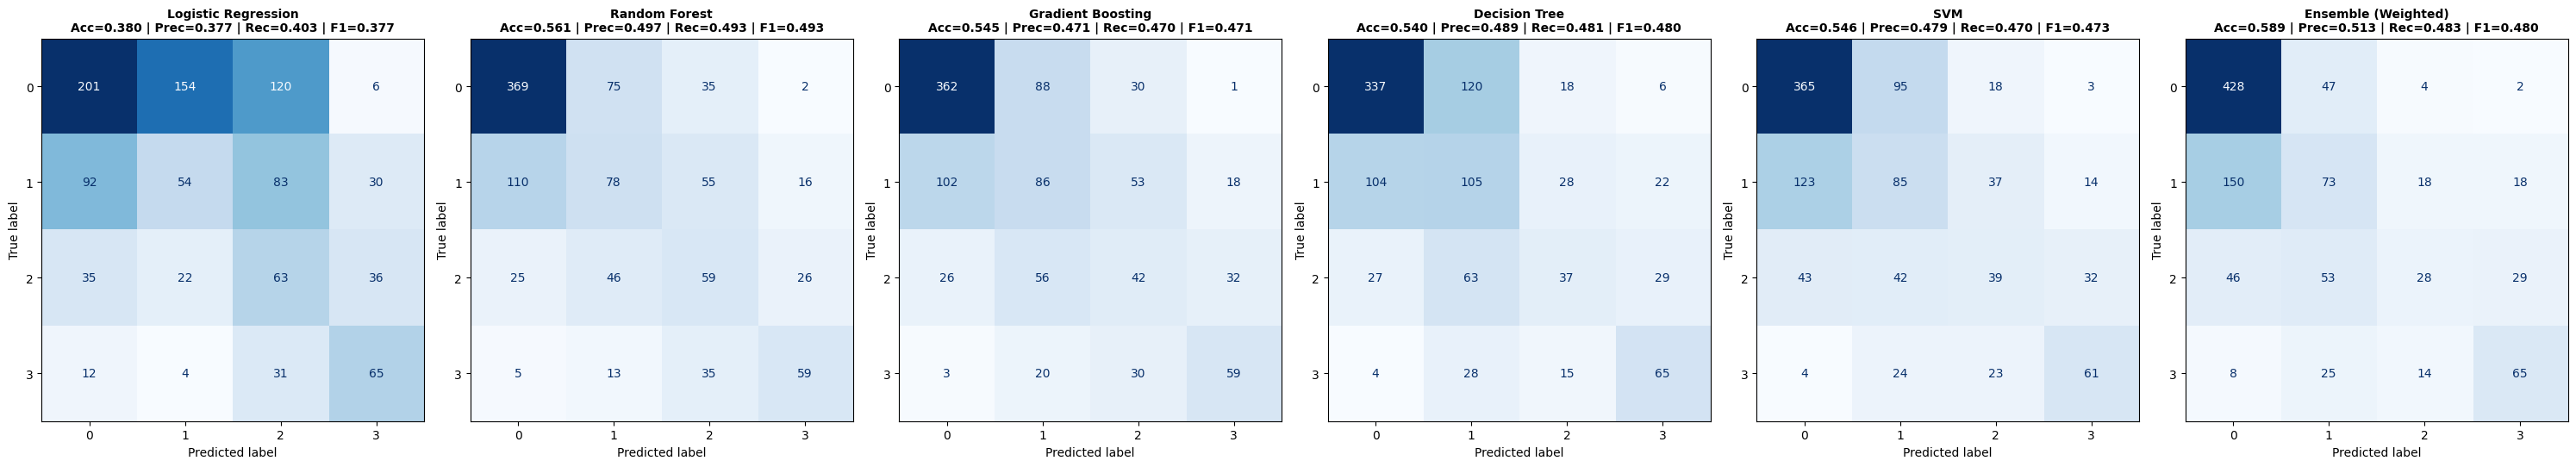

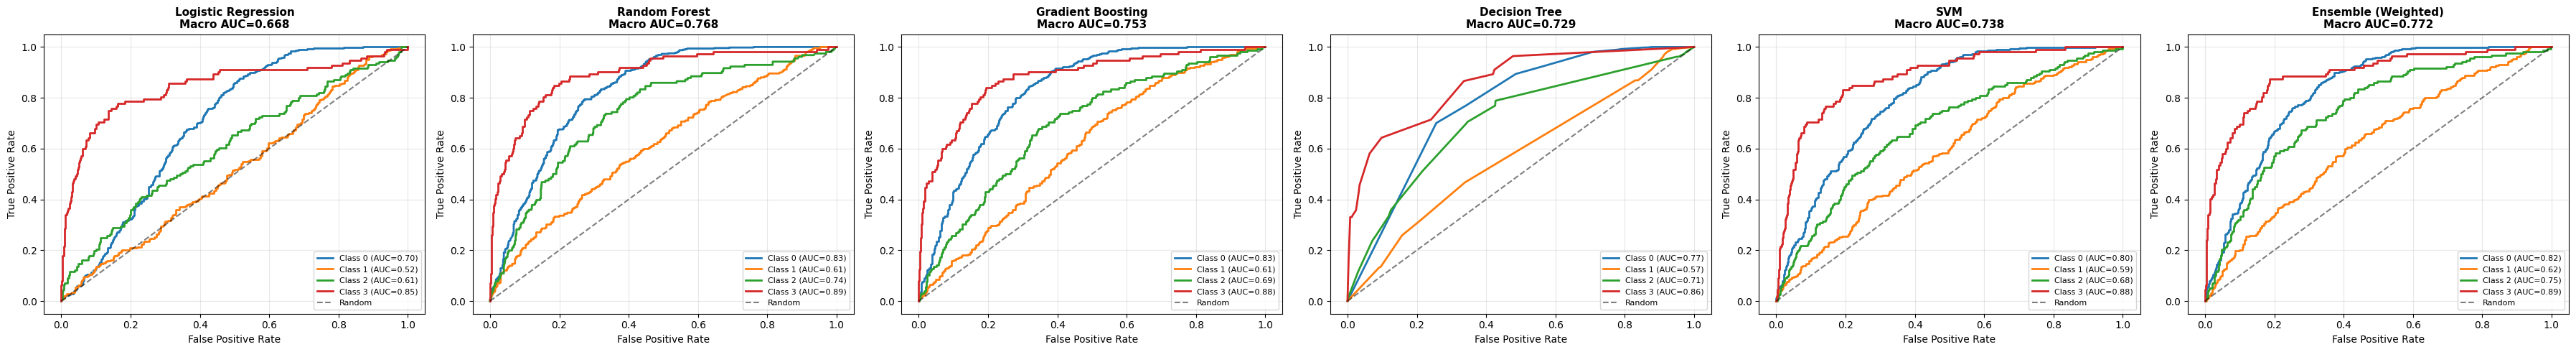

In [106]:
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Unpack all three return values
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train, X_test_reduced, y_test
)

# Show metrics table
print(summary_df_reduced)
# Plot feature importance
plot_feature_importance(models_reduced, feature_names=selected_features, title_prefix="Reduced Features - ")

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_reduced, summary_df_reduced)
show_roc_curves(models_reduced, X_test_reduced, y_test)


### Split Dataset

                         ECONOMY GROUP SUMMARY

Total DataFrames created:
  • Lower Economies: 2426 rows
  • Upper Economies: 2250 rows
  • Total: 9209 rows

RECESSION RISK DISTRIBUTION BY ECONOMY GROUP

📊 LOWER ECONOMIES (Africa, Asia, South America):
--------------------------------------------------------------------------------
RecessionRisk
0    1163
1     544
2     358
3     361
Name: count, dtype: int64

Total Lower Economy samples: 2426

Detailed breakdown:
  Class 0 ( No Risk):  1163 samples ( 47.94%)
  Class 1 (    Mild):   544 samples ( 22.42%)
  Class 2 (Moderate):   358 samples ( 14.76%)
  Class 3 (    High):   361 samples ( 14.88%)

--------------------------------------------------------------------------------

📊 UPPER ECONOMIES (Europe, North America, Oceania):
--------------------------------------------------------------------------------
RecessionRisk
0    1466
1     396
2     179
3     209
Name: count, dtype: int64

Total Upper Economy samples: 2250

Detailed break

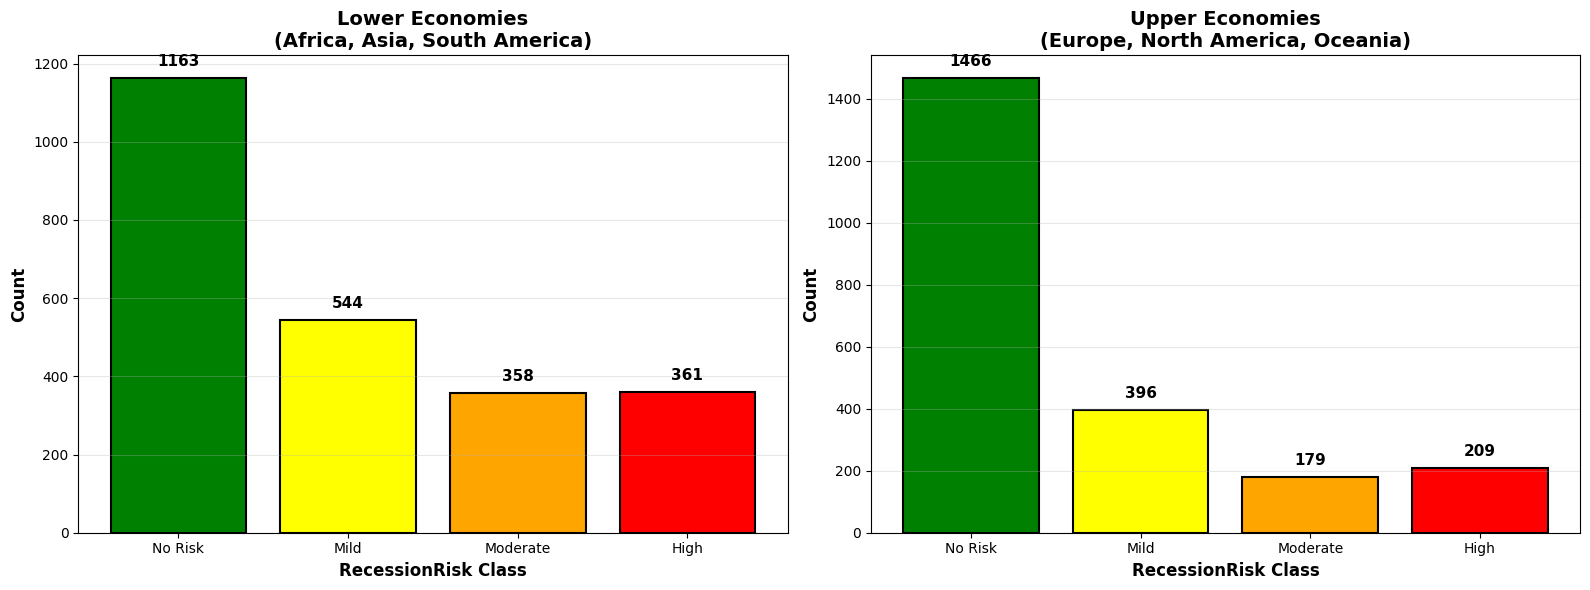


COUNTRIES BY ECONOMY GROUP

Lower Economies Countries:
  Total: 50 countries
  Afghanistan, Algeria, Argentina, Bolivia, Botswana, Brazil, Cabo_Verde, Cameroon, Chile, China...

Upper Economies Countries:
  Total: 47 countries
  Albania, Australia, Austria, Barbados, Belgium, Bosnia_and_Herzegovina, Bulgaria, Canada, Costa_Rica, Croatia...



In [107]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
    'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
    'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
    'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
    'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
    'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
    'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
    'Australia': 'Oceania', 'New_Zealand': 'Oceania',
    'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
    'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',

    'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
    'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
    'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
    'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
    'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
    'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
    'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
    'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
    'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
    'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
    'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
    'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
    'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
    'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
    'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America',
    'Botswana': 'Africa', 'Cameroon': 'Africa', 'Djibouti': 'Africa', 'Equatorial_Guinea': 'Africa',
    'Eswatini': 'Africa','Guyana': 'South_America','Lesotho': 'Africa','Mali': 'Africa',
    'Mauritania': 'Africa','Namibia': 'Africa','Niger': 'Africa','Oman': 'Asia','Yemen': 'Asia',
    'Zambia': 'Africa','St._Kitts_and_Nevis': 'North_America'
}

    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("=" * 80)
print(" " * 25 + "ECONOMY GROUP SUMMARY")
print("=" * 80)

print(f"\nTotal DataFrames created:")
print(f"  • Lower Economies: {len(df_Lower_Economies)} rows")
print(f"  • Upper Economies: {len(df_Upper_Economies)} rows")
print(f"  • Total: {len(df_filtered_copy)} rows")

# --- Show RecessionRisk distribution per economy group ---
print("\n" + "=" * 80)
print("RECESSION RISK DISTRIBUTION BY ECONOMY GROUP")
print("=" * 80)

print("\n📊 LOWER ECONOMIES (Africa, Asia, South America):")
print("-" * 80)
lower_risk_dist = df_Lower_Economies['RecessionRisk'].value_counts().sort_index()
print(lower_risk_dist)
print(f"\nTotal Lower Economy samples: {len(df_Lower_Economies)}")

print("\nDetailed breakdown:")
for risk_class in range(4):
    count = lower_risk_dist.get(risk_class, 0)
    pct = (count / len(df_Lower_Economies)) * 100 if len(df_Lower_Economies) > 0 else 0
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    print(f"  Class {risk_class} ({risk_label:>8}): {count:>5} samples ({pct:>6.2f}%)")

print("\n" + "-" * 80)
print("\n📊 UPPER ECONOMIES (Europe, North America, Oceania):")
print("-" * 80)
upper_risk_dist = df_Upper_Economies['RecessionRisk'].value_counts().sort_index()
print(upper_risk_dist)
print(f"\nTotal Upper Economy samples: {len(df_Upper_Economies)}")

print("\nDetailed breakdown:")
for risk_class in range(4):
    count = upper_risk_dist.get(risk_class, 0)
    pct = (count / len(df_Upper_Economies)) * 100 if len(df_Upper_Economies) > 0 else 0
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    print(f"  Class {risk_class} ({risk_label:>8}): {count:>5} samples ({pct:>6.2f}%)")

# --- Comparative Analysis ---
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS: LOWER vs UPPER ECONOMIES")
print("=" * 80)

print(f"\n{'Risk Class':<15} {'Lower Econ':<20} {'Upper Econ':<20} {'Difference':<15}")
print("-" * 80)

for risk_class in range(4):
    lower_count = lower_risk_dist.get(risk_class, 0)
    upper_count = upper_risk_dist.get(risk_class, 0)
    
    lower_pct = (lower_count / len(df_Lower_Economies)) * 100 if len(df_Lower_Economies) > 0 else 0
    upper_pct = (upper_count / len(df_Upper_Economies)) * 100 if len(df_Upper_Economies) > 0 else 0
    
    diff = lower_pct - upper_pct
    risk_label = ['No Risk', 'Mild', 'Moderate', 'High'][risk_class]
    
    print(f"{risk_label:<15} {lower_count:>5} ({lower_pct:>5.1f}%)     {upper_count:>5} ({upper_pct:>5.1f}%)     {diff:>+6.1f}%")

# --- Visualization ---
print("\n" + "=" * 80)
print("VISUALIZATION: Recession Risk by Economy Group")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lower Economies
lower_counts = [lower_risk_dist.get(i, 0) for i in range(4)]
axes[0].bar(range(4), lower_counts, color=['green', 'yellow', 'orange', 'red'], 
            edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Lower Economies\n(Africa, Asia, South America)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(['No Risk', 'Mild', 'Moderate', 'High'])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(lower_counts):
    if count > 0:
        axes[0].text(i, count + max(lower_counts)*0.02, str(count), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Upper Economies
upper_counts = [upper_risk_dist.get(i, 0) for i in range(4)]
axes[1].bar(range(4), upper_counts, color=['green', 'yellow', 'orange', 'red'], 
            edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('RecessionRisk Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Upper Economies\n(Europe, North America, Oceania)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(['No Risk', 'Mild', 'Moderate', 'High'])
axes[1].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(upper_counts):
    if count > 0:
        axes[1].text(i, count + max(upper_counts)*0.02, str(count), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# --- Countries per economy group ---
print("\n" + "=" * 80)
print("COUNTRIES BY ECONOMY GROUP")
print("=" * 80)

print("\nLower Economies Countries:")
lower_countries = sorted(df_Lower_Economies['Country'].unique())
print(f"  Total: {len(lower_countries)} countries")
print(f"  {', '.join(lower_countries[:10])}...")  # Show first 10

print("\nUpper Economies Countries:")
upper_countries = sorted(df_Upper_Economies['Country'].unique())
print(f"  Total: {len(upper_countries)} countries")
print(f"  {', '.join(upper_countries[:10])}...")  # Show first 10

print("\n" + "=" * 80)

# 6. Economy-Specific Analysis

## Upper Economies - Full Features

c:\Users\ningw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.585556       0.520000           0.390197   
Random Forest              0.747778       0.793333           0.649688   
Gradient Boosting          0.853889       0.802222           0.582486   
Decision Tree              0.671111       0.764444           0.502224   
SVM                        0.785556       0.626667           0.409717   
Ensemble (Weighted)        0.872778       0.833333           0.656616   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.445026    0.383357       0.590456  
Random Forest              0.564247    0.565008       0.803707  
Gradient Boosting          0.498677    0.514622       0.809627  
Decision Tree              0.489811    0.435827       0.771086  
SVM                        0.407849    0.379849       0.675279  
Ensemble (Weighted)        0.431408    0.483170       0.810593  


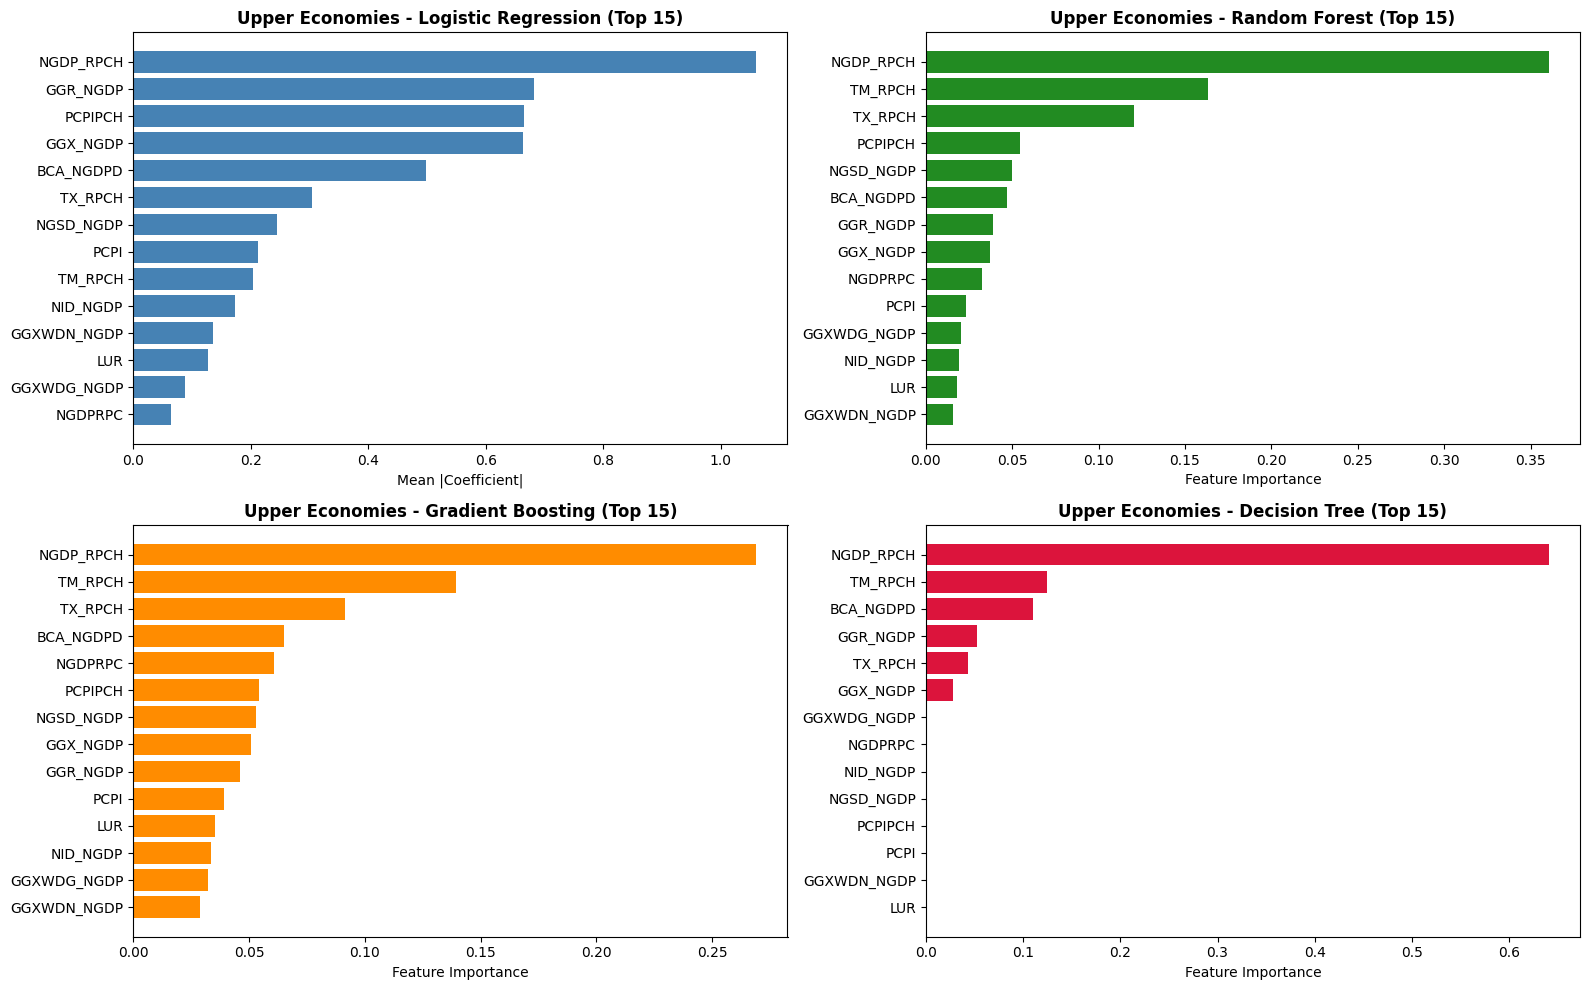

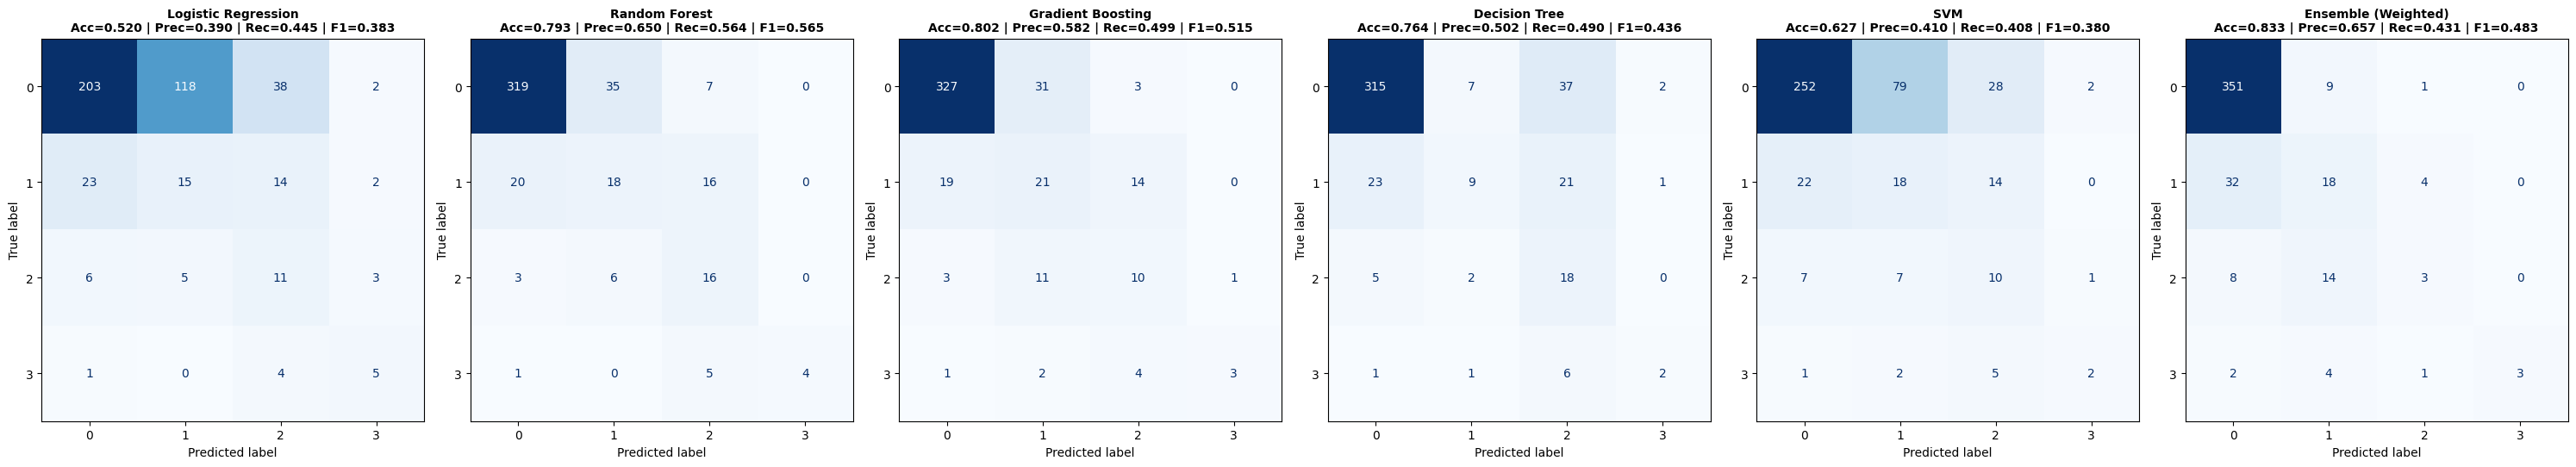

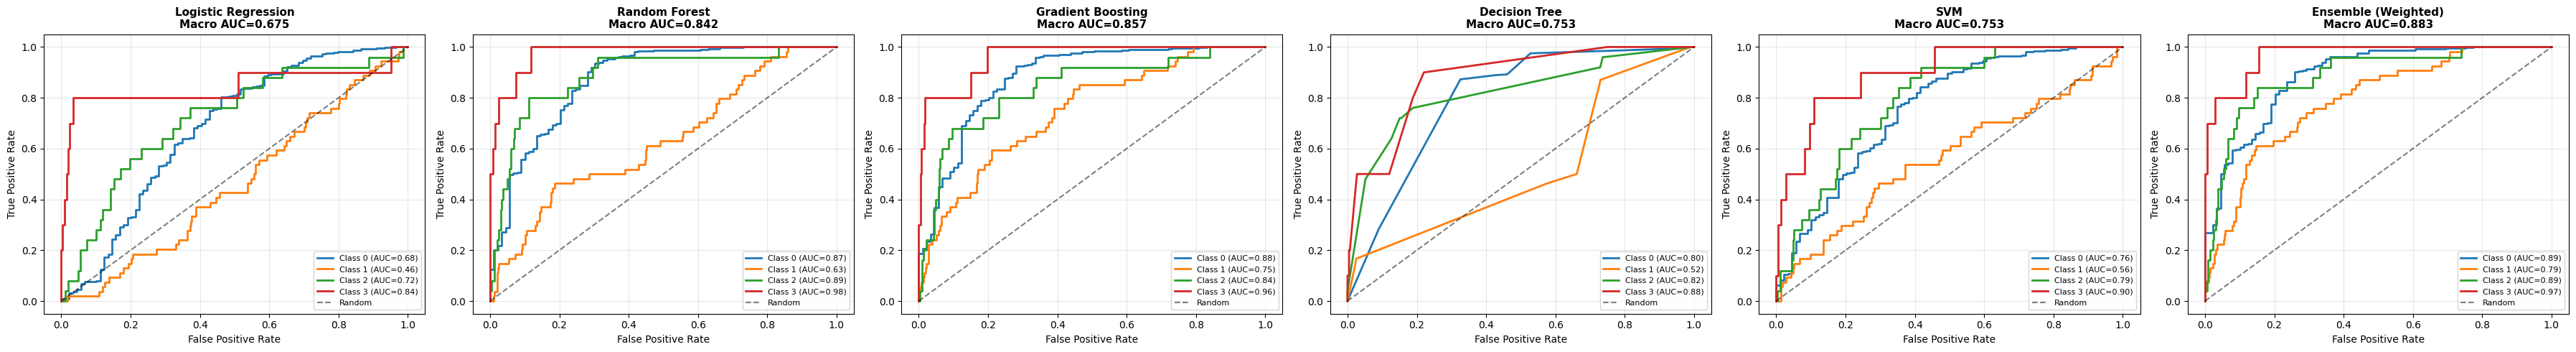

In [108]:
# Prepare data
X = df_Upper_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Upper_Economies["RecessionRisk"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train, X_test, y_test
)

# Show metrics table
print(summary_df_upper)

# Plot feature importance
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, summary_df_upper)
# ✅ Show ROC curves + AUC for upper-economy models
show_roc_curves(models_upper, X_test, y_test)

## Lower Economies - Full Features

                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.482990       0.390947           0.326650   
Random Forest              0.671649       0.652263           0.419536   
Gradient Boosting          0.787113       0.609053           0.414488   
Decision Tree              0.577320       0.639918           0.445128   
SVM                        0.663402       0.526749           0.363976   
Ensemble (Weighted)        0.793299       0.722222           0.487563   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.364221    0.309141       0.445155  
Random Forest              0.469103    0.423132       0.651049  
Gradient Boosting          0.481320    0.432222       0.624856  
Decision Tree              0.480696    0.435432       0.640939  
SVM                        0.431401    0.372824       0.560204  
Ensemble (Weighted)        0.489420    0.453269       0.678718  


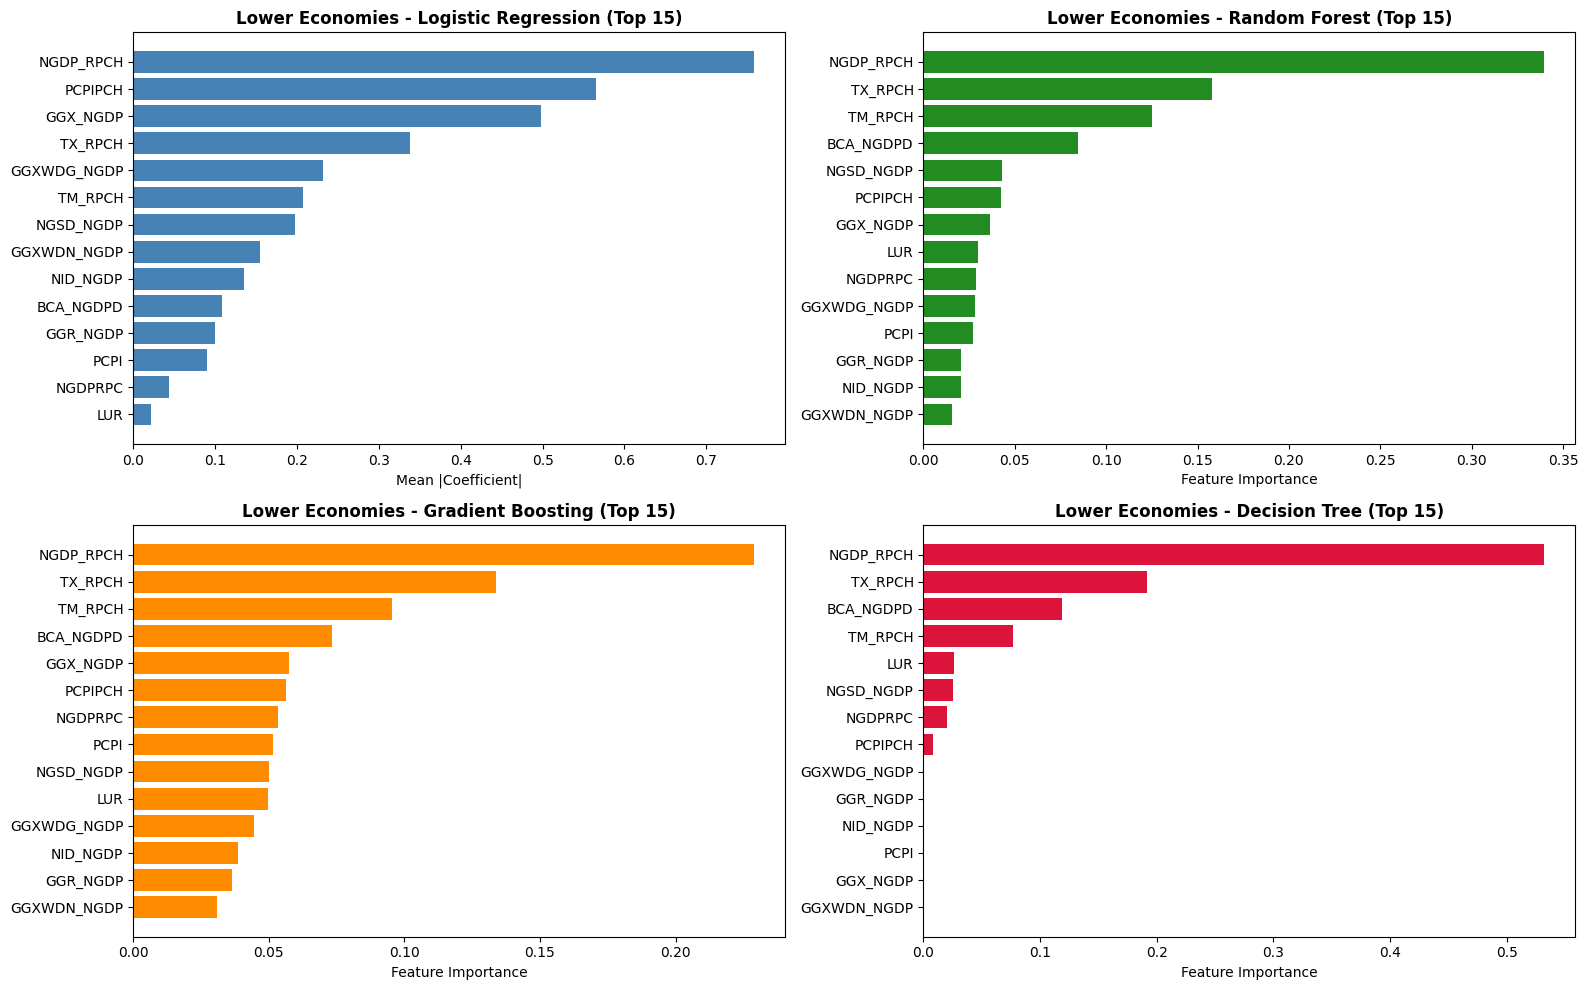

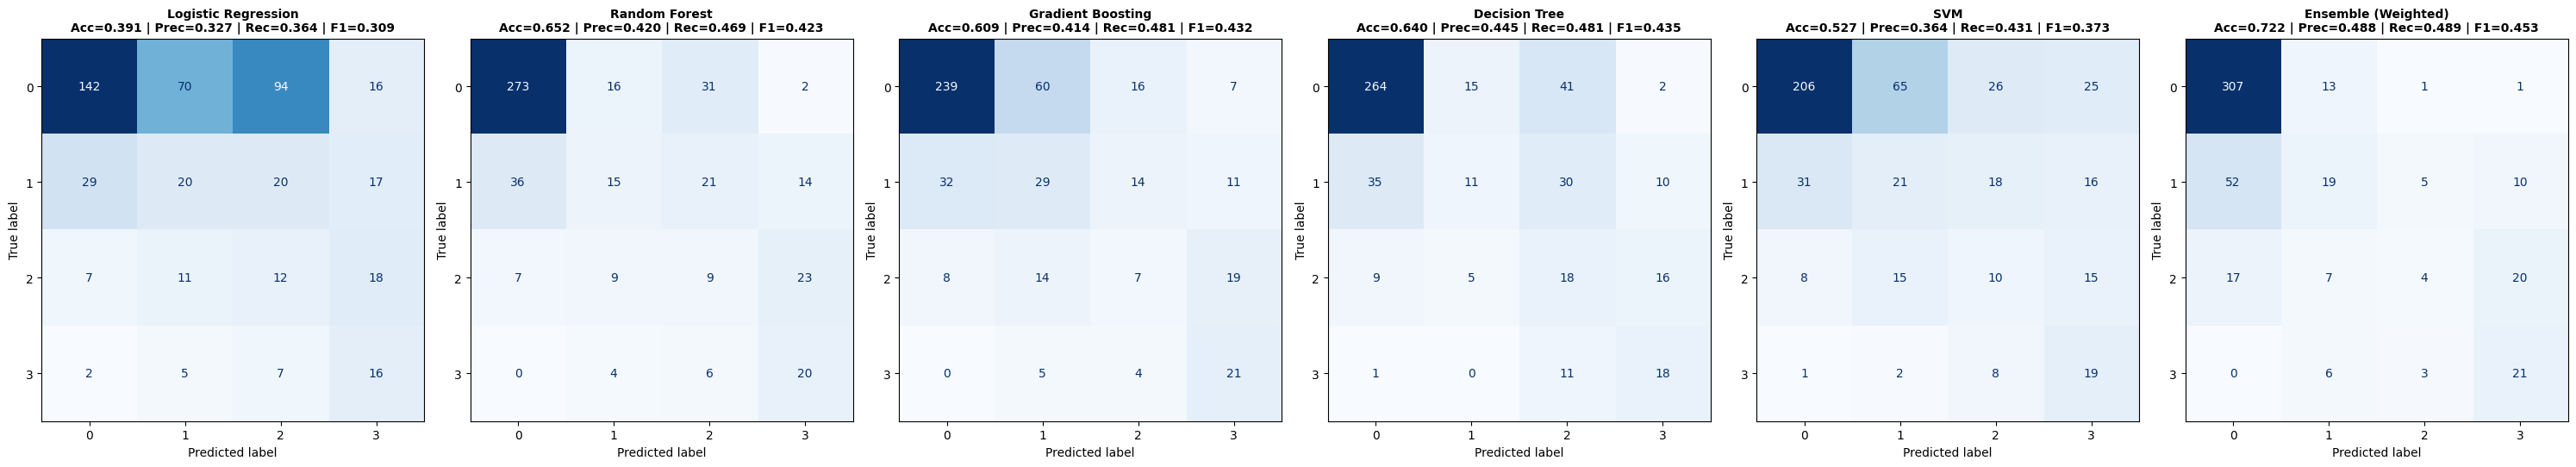

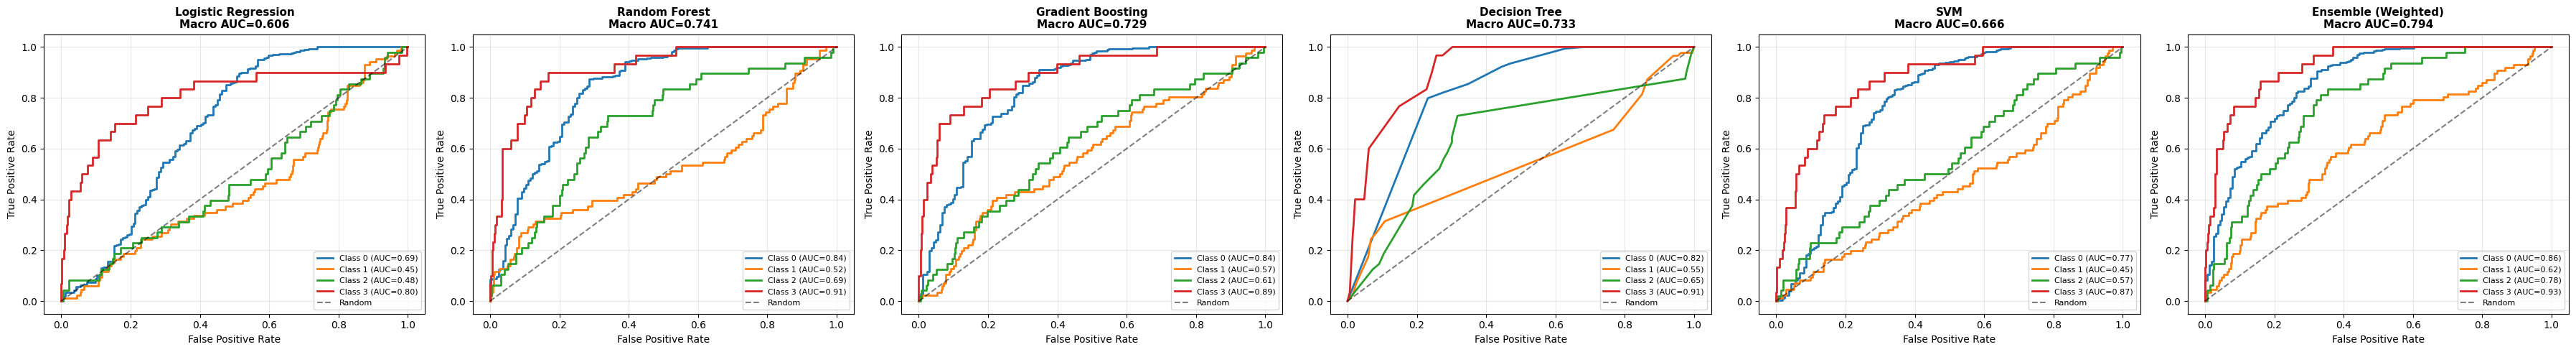

In [109]:
# Prepare data for Lower Economies
X = df_Lower_Economies.drop(columns=["RecessionRisk", "Country"])
y = df_Lower_Economies["RecessionRisk"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train, X_test, y_test
)

# Show metrics table
print(summary_df_lower)

# Plot feature importance
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")


# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, summary_df_lower)
# ✅ Show ROC curves + AUC for lower-economy models
show_roc_curves(models_lower, X_test, y_test)

## Upper Economies - Reduced Features

Upper Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.528333       0.382222           0.431496   
Random Forest              0.713889       0.682222           0.517056   
Gradient Boosting          0.790000       0.731111           0.559741   
Decision Tree              0.634444       0.546667           0.455680   
SVM                        0.726667       0.731111           0.501848   
Ensemble (Weighted)        0.829444       0.840000           0.654197   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.413579    0.343942       0.459551  
Random Forest              0.469517    0.446604       0.724753  
Gradient Boosting          0.500823    0.504909       0.760389  
Decision Tree              0.433714    0.406169       0.623172  
SVM                        0.474012    0.467387       0.752230  
Ensemble (Weighted)        0.486464    0.537701      

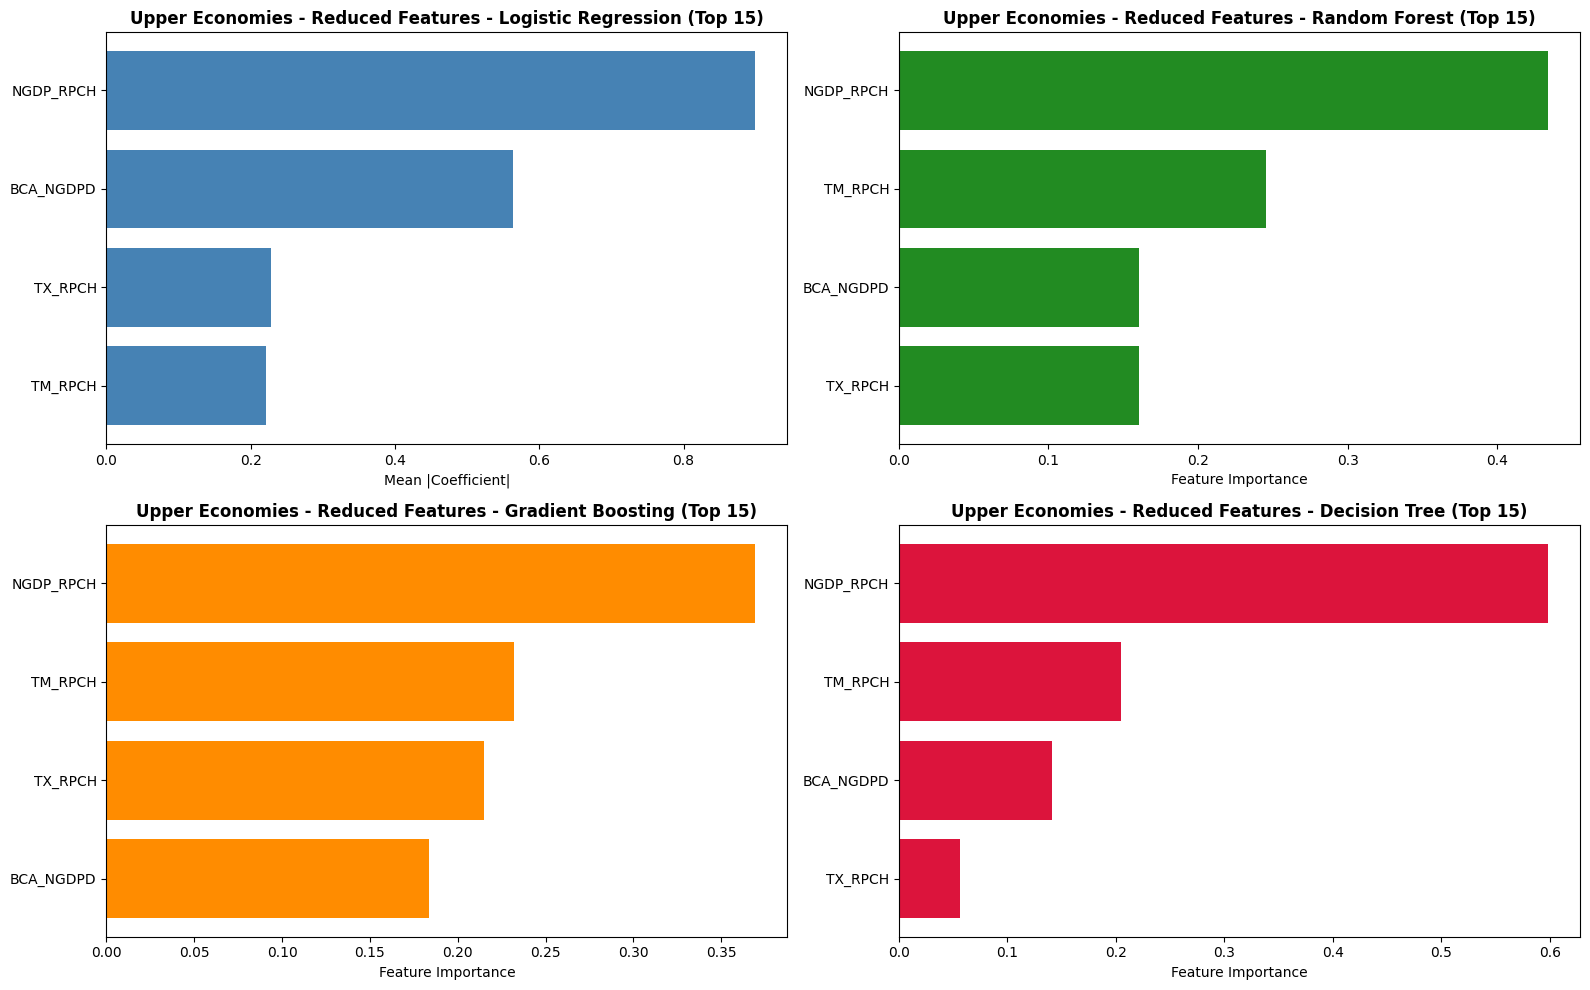

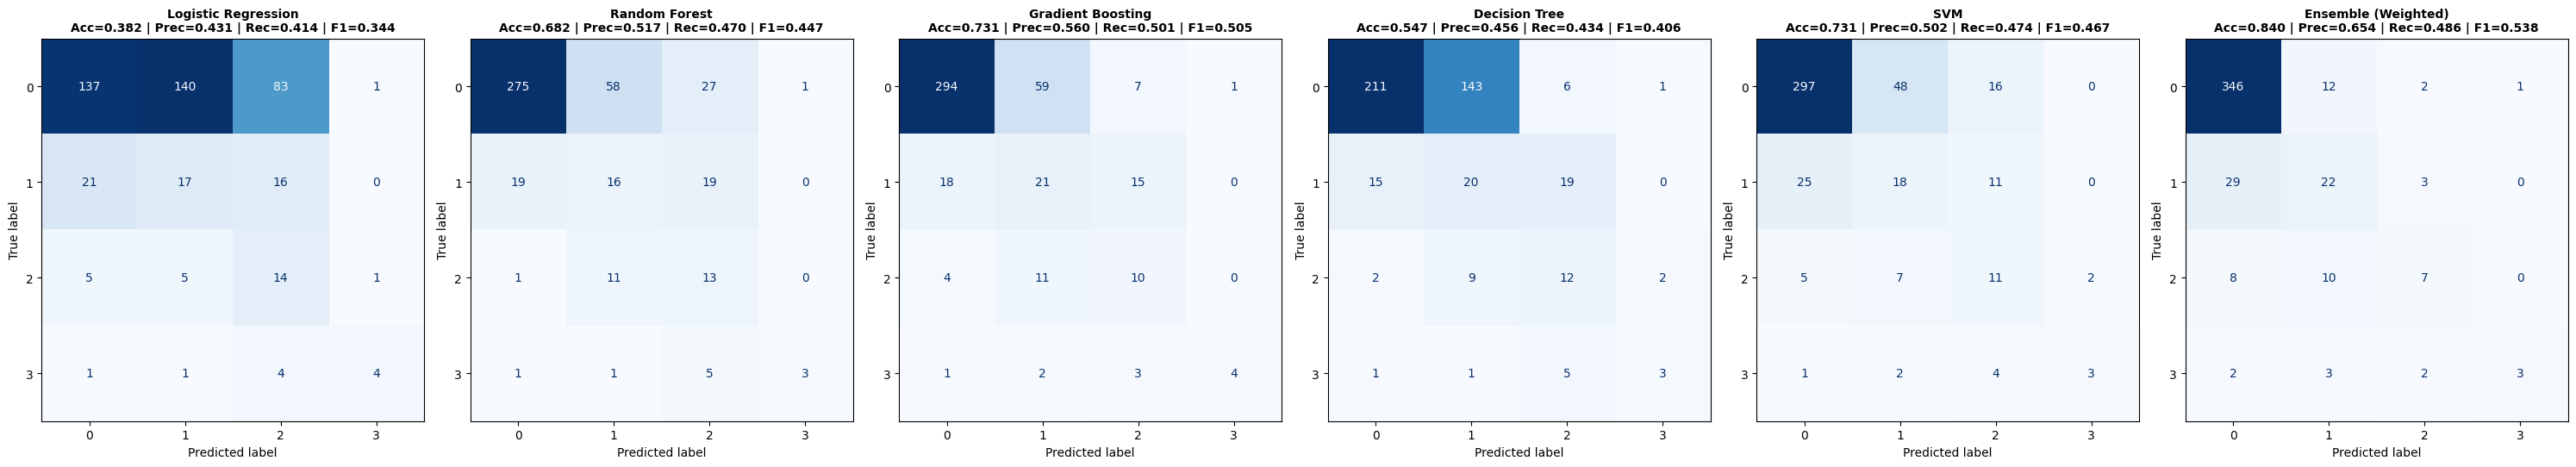

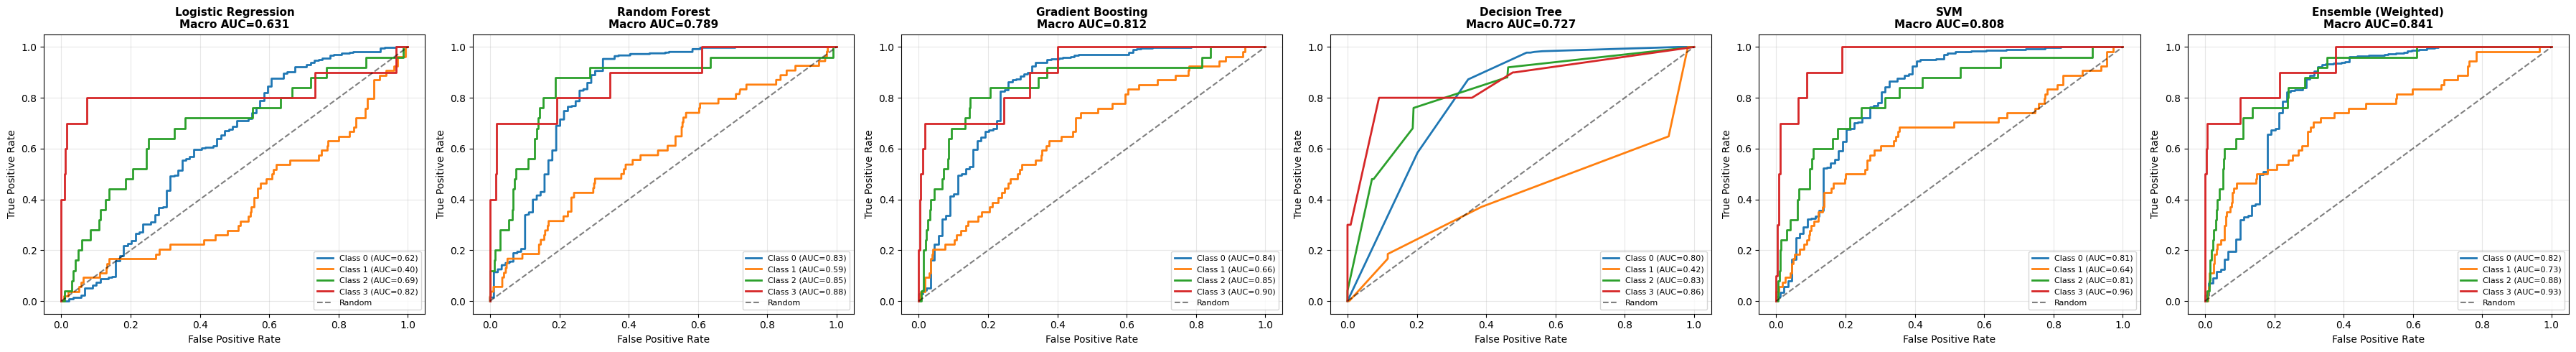

In [110]:
X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["RecessionRisk"]

split_index_upper = int(len(X_upper) * 0.8)
X_train_upper = X_upper.iloc[:split_index_upper]
X_test_upper = X_upper.iloc[split_index_upper:]
y_train_upper = y_upper.iloc[:split_index_upper]
y_test_upper = y_upper.iloc[split_index_upper:]

# ✅ Unpack all three return values
models_upper_reduced, summary_df_upper_reduced, confusion_mats_upper_reduced = train_all_models(
    X_train_upper, y_train_upper, X_test_upper, y_test_upper
)

print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper_reduced)

# Feature importance
plot_feature_importance(
    models_upper_reduced,
    feature_names=selected_features,
    title_prefix="Upper Economies - Reduced Features - "
)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper_reduced, summary_df_upper_reduced)

# ✅ Show ROC curves + AUC for reduced-feature upper-economy models
show_roc_curves(models_upper_reduced, X_test_upper, y_test_upper)


## Lower Economies - Reduced Features

Lower Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision (macro)  \
Logistic Regression        0.465464       0.265432           0.299382   
Random Forest              0.645876       0.658436           0.440743   
Gradient Boosting          0.741237       0.619342           0.430124   
Decision Tree              0.591753       0.685185           0.468747   
SVM                        0.613402       0.644033           0.441782   
Ensemble (Weighted)        0.726804       0.691358           0.420106   

                     Recall (macro)  F1 (macro)  F1 (weighted)  
Logistic Regression        0.329050    0.258858       0.311562  
Random Forest              0.492285    0.450874       0.653297  
Gradient Boosting          0.482589    0.448625       0.633915  
Decision Tree              0.507775    0.470681       0.674345  
SVM                        0.467617    0.439469       0.649297  
Ensemble (Weighted)        0.461695    0.425456      

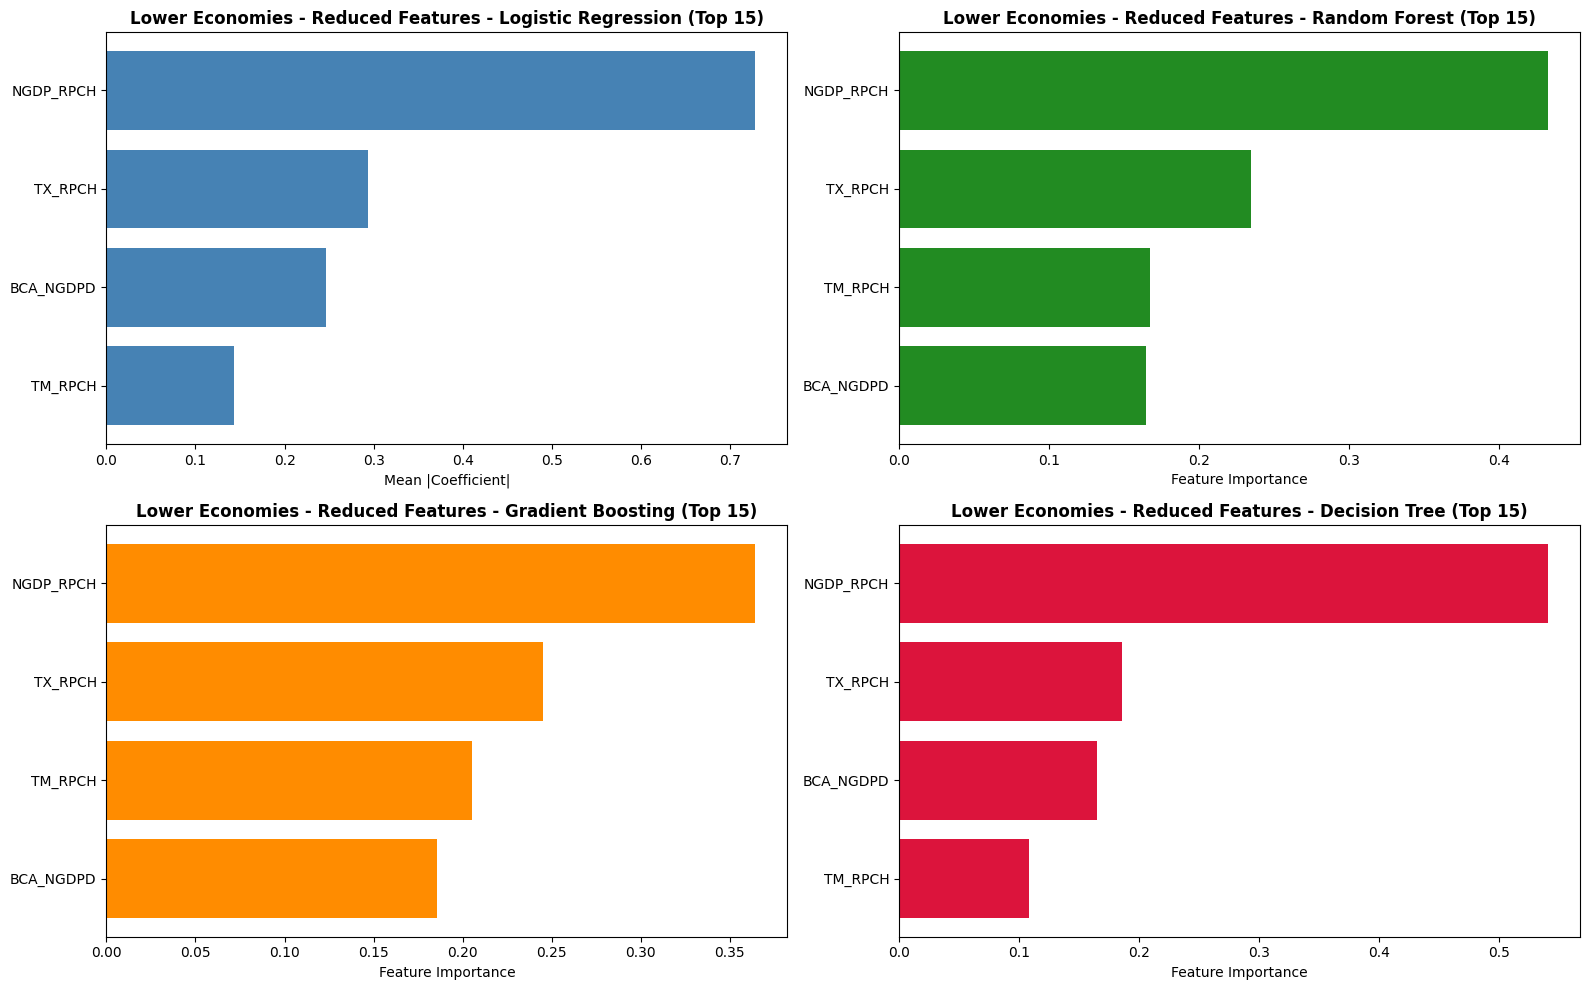

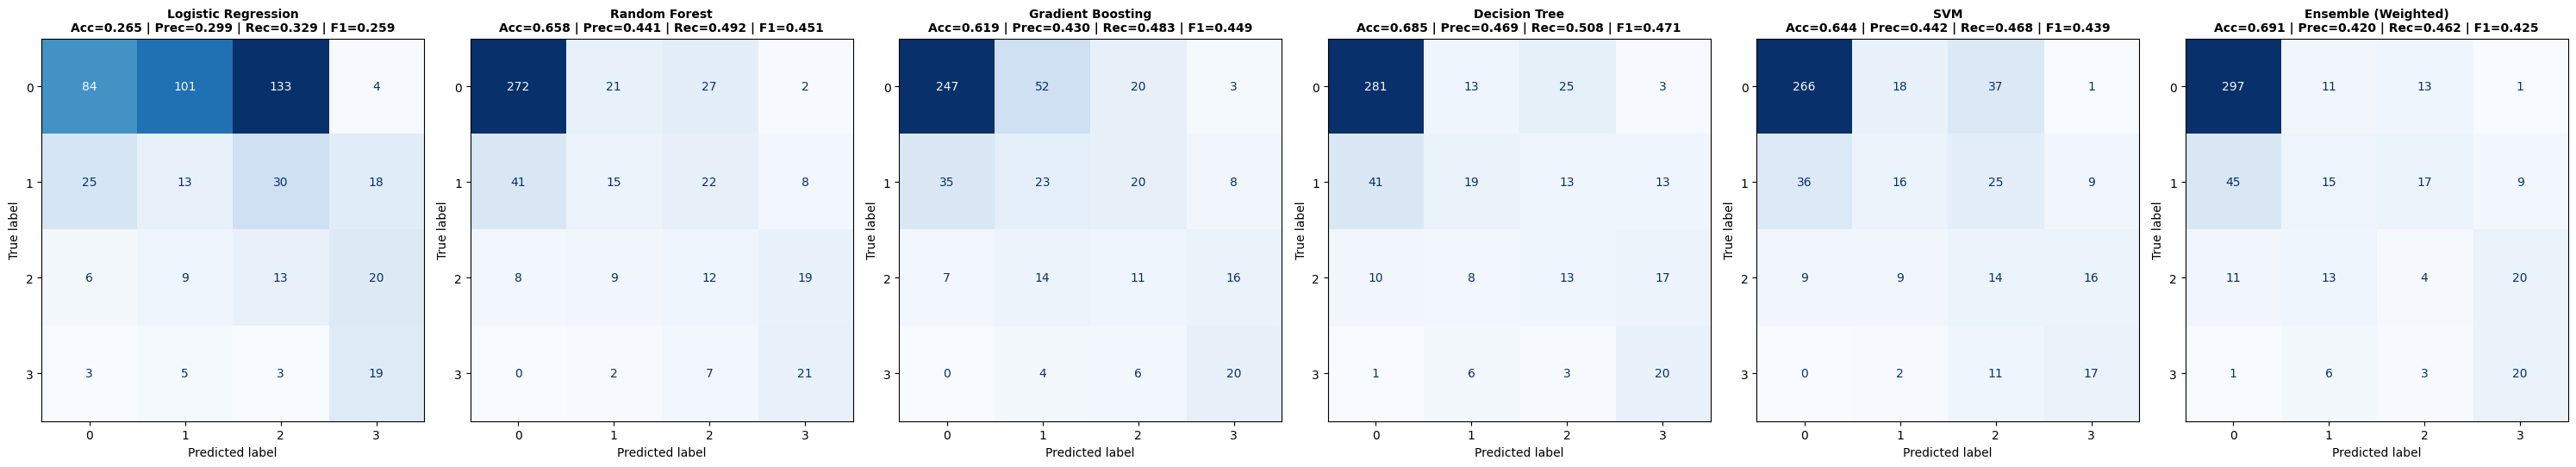

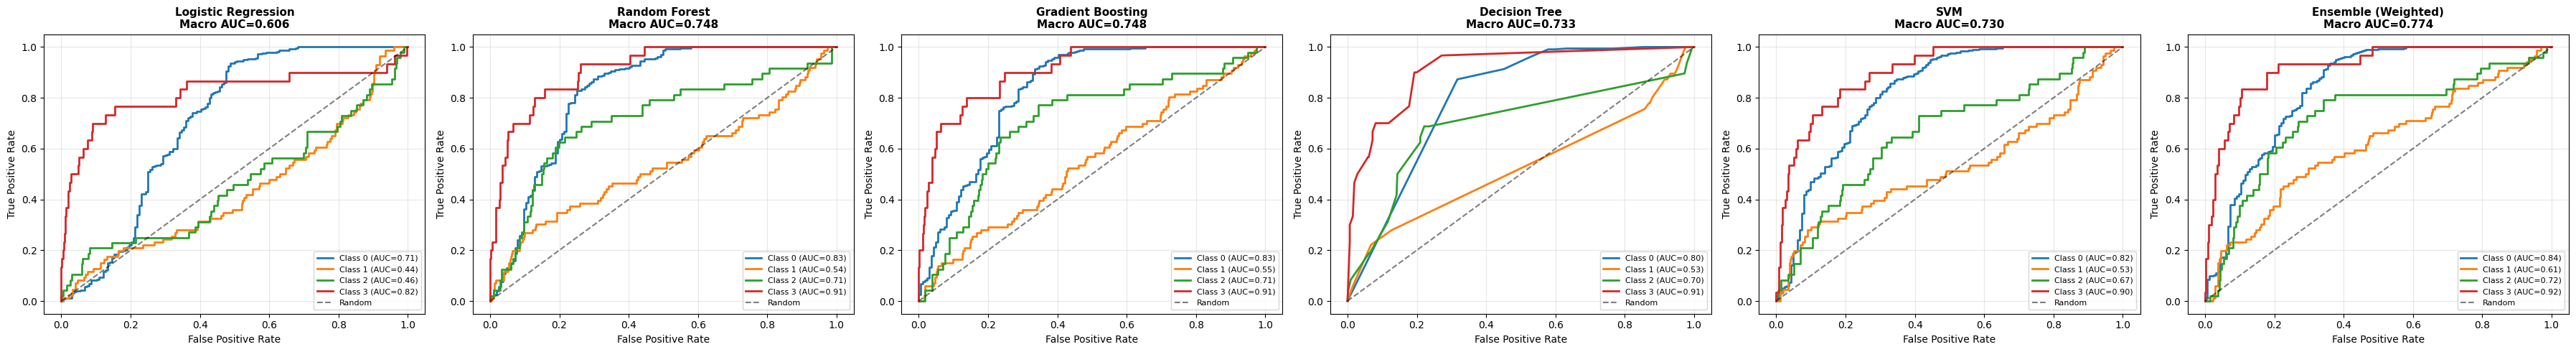

In [111]:
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["RecessionRisk"]

split_index_lower = int(len(X_lower) * 0.8)
X_train_lower = X_lower.iloc[:split_index_lower]
X_test_lower = X_lower.iloc[split_index_lower:]
y_train_lower = y_lower.iloc[:split_index_lower]
y_test_lower = y_lower.iloc[split_index_lower:]

# ✅ Unpack all three return values
models_lower_reduced, summary_df_lower_reduced, confusion_mats_lower_reduced = train_all_models(
    X_train_lower, y_train_lower, X_test_lower, y_test_lower
)

print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower_reduced)

# Feature importance
plot_feature_importance(
    models_lower_reduced,
    feature_names=selected_features,
    title_prefix="Lower Economies - Reduced Features - "
)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower_reduced, summary_df_lower_reduced)

# ✅ Show ROC curves + AUC for reduced-feature lower-economy models
show_roc_curves(models_lower_reduced, X_test_lower, y_test_lower)


# Prediction 2026-2030

In [112]:
df_predict = df_pivot.loc[df_pivot.index > 2025]
df_predict_original = df_predict.copy()
df_predict = df_predict.drop(columns=["RecessionRisk", "Country"])

df_predict_original['Continent'] = df_predict_original['Country'].astype(str).apply(country_to_continent)

continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_predict_original['EconomyGroup'] = df_predict_original['Continent'].map(continent_to_economy)

df_predict_lower = df_predict_original[df_predict_original['EconomyGroup'] == 'Lower_Economies']

df_predict_upper = df_predict_original[df_predict_original['EconomyGroup'] == 'Upper_Economies']

print("Created economy-specific prediction DataFrames from df_predict_original:")
print(f" - Lower_Economies predictions: {len(df_predict_lower)} rows")
print(f" - Upper_Economies predictions: {len(df_predict_upper)} rows")

Created economy-specific prediction DataFrames from df_predict_original:
 - Lower_Economies predictions: 227 rows
 - Upper_Economies predictions: 235 rows


In [113]:
# ============================================================
#                  PREDICTION FUNCTION (MULTICLASS)
# ============================================================
def make_predictions(models, df_predict):
    """
    Return multiclass predictions (0,1,2,3) from every model in one dataframe.
    """
    predictions = {}

    for name, model in models.items():
        # If model supports predict_proba → use argmax over classes
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(df_predict)
            predictions[name] = proba.argmax(axis=1)
        else:
            predictions[name] = model.predict(df_predict)

    return pd.DataFrame(predictions, index=df_predict.index)


# ============================================================
#      MULTICLASS RECESSION RISK COUNTS PER MODEL (PLOT)
# ============================================================
def plot_recession_counts_per_model(df_with_country, title):
    """
    Grouped bar plot per year per model:
    - X: Year
    - Bars: counts of each RecessionRisk class (0,1,2,3)
    - Facets: one subplot per model

    Expects df_with_country with columns:
        ['Year','Country', <model prediction columns>]
    where model columns contain multiclass predictions (0–3).
    """

    # Melt to long format
    df_long = df_with_country.melt(
        id_vars=['Year', 'Country'],
        var_name='Model',
        value_name='Prediction'
    )

    # Count per (Year, Model, Prediction)
    counts = (
        df_long.groupby(['Year', 'Model', 'Prediction'])
               .size()
               .reset_index(name='Count')
    )

    # Pivot → columns become risk classes (0,1,2,3)
    counts_pivot = (
        counts.pivot(index=['Year', 'Model'], columns='Prediction', values='Count')
              .fillna(0)
    ).reset_index()

    # Identify risk classes present
    risk_classes = sorted([c for c in counts_pivot.columns if isinstance(c, int)])

    # Reorder columns: Year, Model, then risk classes
    counts_pivot = counts_pivot[['Year', 'Model'] + risk_classes]

    # Plotting layout
    models = counts_pivot['Model'].unique()
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]

        # Extract model-specific data
        mdf = counts_pivot[counts_pivot['Model'] == model].set_index('Year')[risk_classes]

        # Plot grouped bars
        plot = mdf.plot(kind='bar', ax=ax)

        ax.set_title(model)
        ax.set_ylabel('Number of countries')
        ax.set_xlabel('Year')
        ax.legend(title='RecessionRisk')

        # Annotate bars
        for p in plot.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(
                    f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=8, color='black', xytext=(0, 2),
                    textcoords='offset points'
                )

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()


In [114]:
df_predict_original.drop(columns=["RecessionRisk"], inplace=True)
df_predict_original

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,,
2026,Albania,-3.050,27.898,53.500000,46.714000,30.450,8.800000,822629.982,3.468,22.120000,26.460000,133.147,2.665,3.294000,6.092000,Europe,Upper_Economies
2026,Tanzania,-2.866,16.496,45.794000,43.869771,19.277,8.615541,2548922.358,6.294,36.168000,39.033000,461.169,4.011,8.229000,6.487000,Unknown,NaN
2026,Algeria,-4.591,24.136,66.950000,64.368000,37.237,8.615541,201264.945,3.004,33.357000,37.948000,302.482,3.646,2.202000,2.912000,Africa,Lower_Economies
2026,Tajikistan,-2.083,27.868,28.167000,43.869771,30.369,8.615541,45.838,4.960,22.052000,24.136000,2276.783,5.500,6.210000,7.375000,Unknown,NaN
2026,Zambia,2.567,22.575,56.173166,43.869771,26.545,8.615541,8591.965,6.817,34.974000,32.407000,572.131,9.156,5.889000,13.511000,Africa,Lower_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Tajikistan,-2.240,27.489,29.198000,43.869771,29.750,8.615541,51.568,4.500,20.603000,22.843000,2922.129,6.500,0.000000,0.000000,Unknown,NaN
2030,Tanzania,-2.477,16.460,40.381000,43.869771,19.135,8.615541,2904355.925,6.196,39.159000,41.636000,539.538,4.001,8.475000,3.836000,Unknown,NaN
2030,The_Gambia,-0.561,20.622,44.413000,43.869771,20.980,8.615541,31800.257,5.002,20.780000,21.340000,1210.157,5.000,0.647000,7.557000,Unknown,NaN


In [115]:
df_predict_upper.drop(columns=["RecessionRisk"], inplace=True)
df_predict_upper

C:\Users\ningw\AppData\Local\Temp\ipykernel_38552\311089533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_upper.drop(columns=["RecessionRisk"], inplace=True)


,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,,
2026,Albania,-3.050,27.898,53.500,46.714,30.450,8.800000,822629.982,3.468,22.120,26.460,133.147,2.665,3.294,6.092,Europe,Upper_Economies
2026,Switzerland,5.239,32.383,35.963,15.496,32.221,2.770000,88020.998,1.611,31.180,25.941,107.989,0.488,4.129,3.901,Europe,Upper_Economies
2026,Czech_Republic,-0.610,40.612,45.583,30.656,42.697,2.400000,599641.534,1.792,24.461,25.070,158.284,2.000,3.148,3.026,Europe,Upper_Economies
2026,Cyprus,-7.839,43.890,55.019,21.168,40.366,4.962000,31022.374,2.663,13.254,21.093,122.127,2.000,5.075,4.145,Europe,Upper_Economies
2026,Sweden,6.020,47.462,33.859,13.131,48.211,8.000000,606654.016,2.168,31.413,25.394,134.347,2.000,2.895,2.593,Europe,Upper_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Australia,-3.502,36.130,49.022,30.119,38.111,4.452000,102054.972,2.272,22.192,25.694,162.983,2.498,2.218,2.768,Oceania,Upper_Economies
2030,Spain,1.252,42.492,92.970,83.672,44.523,10.999000,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,Europe,Upper_Economies
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,8.615541,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,North_America,Upper_Economies


In [116]:
df_predict_lower.drop(columns=["RecessionRisk"], inplace=True)
df_predict_lower

C:\Users\ningw\AppData\Local\Temp\ipykernel_38552\1800171222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict_lower.drop(columns=["RecessionRisk"], inplace=True)


,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Continent,EconomyGroup
Year,,,,,,,,,,,,,,,,,
2026,Algeria,-4.591,24.136000,66.950000,64.368000,37.237000,8.615541,2.012649e+05,3.004,33.357000,37.948000,3.024820e+02,3.646,2.202000,2.912000,Africa,Lower_Economies
2026,Zambia,2.567,22.575000,56.173166,43.869771,26.545000,8.615541,8.591965e+03,6.817,34.974000,32.407000,5.721310e+02,9.156,5.889000,13.511000,Africa,Lower_Economies
2026,Venezuela,-0.479,28.885018,56.173166,43.869771,31.637437,8.615541,2.238718e+06,-5.500,20.686686,24.154875,2.480600e+12,225.003,-12.673000,-8.113000,South_America,Lower_Economies
2026,Mauritania,-4.775,25.061000,47.031000,43.937000,26.173000,8.615541,2.191956e+04,3.714,29.864000,28.023000,2.349090e+02,4.000,3.582000,-3.806000,Africa,Lower_Economies
2026,Djibouti,10.937,18.158000,28.045000,28.045000,20.827000,8.615541,6.943819e+05,5.510,14.974000,4.037000,1.072580e+02,1.860,4.910000,4.526000,Africa,Lower_Economies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Zambia,3.143,23.504000,56.173166,43.869771,25.212000,8.615541,9.534823e+03,4.760,36.964000,33.821000,7.530290e+02,7.000,5.787000,5.527000,Africa,Lower_Economies
2030,South_Africa,-2.191,27.585000,88.732000,87.354000,33.225000,31.405000,7.391343e+04,1.812,11.975000,14.166000,1.284580e+02,4.500,3.308000,3.405000,Africa,Lower_Economies
2030,Argentina,1.223,34.784000,55.671000,43.869771,33.286000,6.000000,1.764355e+04,2.973,18.230000,17.007000,2.503734e+04,7.500,2.752000,3.500000,South_America,Lower_Economies


In [117]:
df_predict_upper_copy = df_predict_upper.copy()
df_predict_lower_copy = df_predict_lower.copy()
df_predict_upper_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)
df_predict_lower_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)

In [118]:
# Reset index once for reuse (assumes Year is the index in df_predict_original)
df_predict_original_reset = df_predict_original.reset_index()
df_predict_upper = df_predict_upper.reset_index()
df_predict_lower = df_predict_lower.reset_index()

   Year     Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026     Albania                    1              0                  0   
1  2026    Tanzania                    1              0                  0   
2  2026     Algeria                    3              0                  3   
3  2026  Tajikistan                    1              0                  0   
4  2026      Zambia                    0              0                  0   

   Decision Tree  SVM  Ensemble (Weighted)  
0              0    0                    0  
1              0    0                    0  
2              0    3                    0  
3              0    0                    0  
4              0    0                    0  


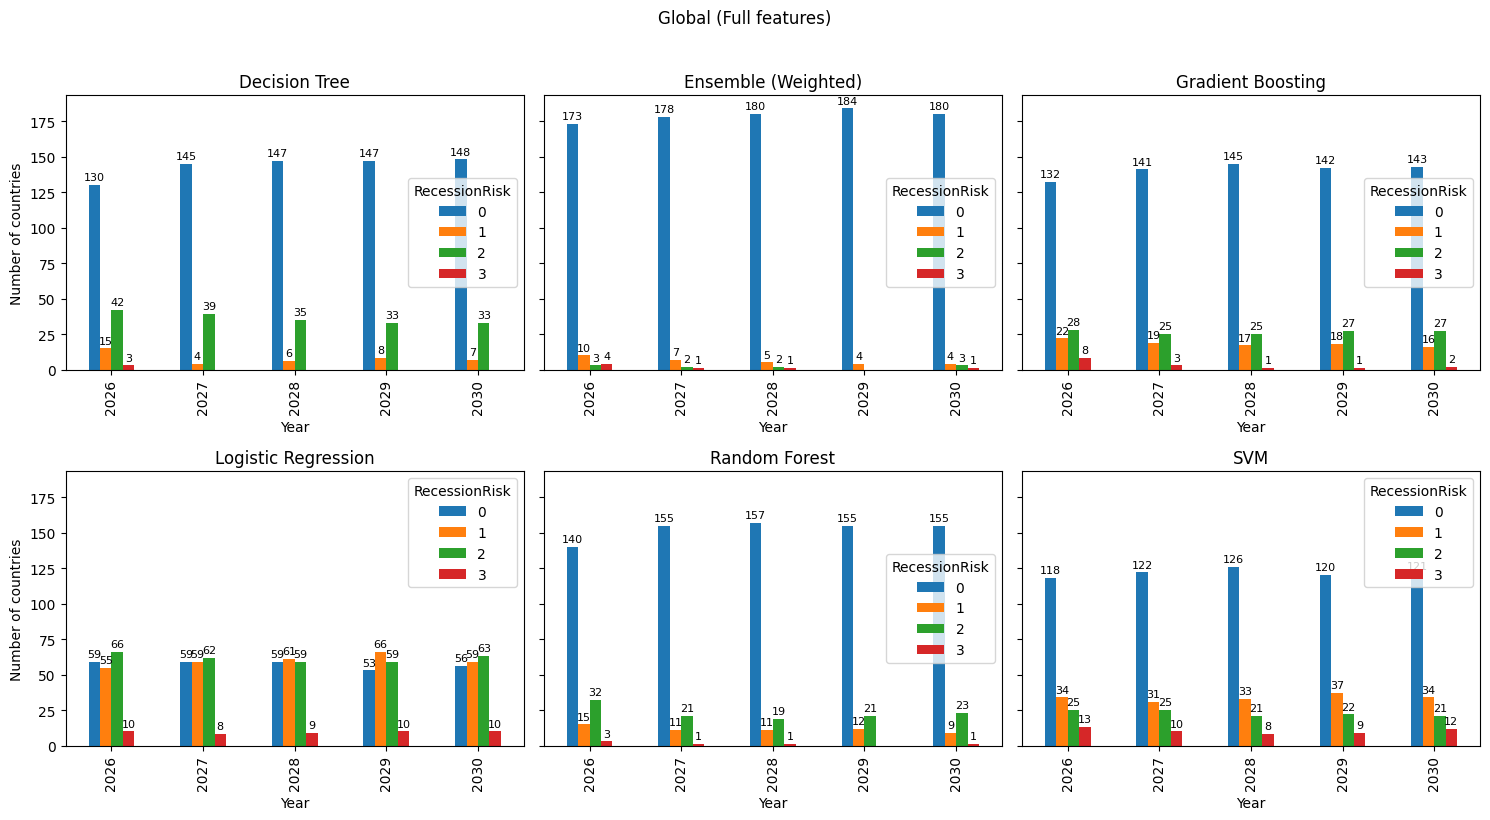

In [119]:
# ============================================================
# Global (all countries, full feature set)
# ============================================================
predictions = make_predictions(models, df_predict)
predictions_global_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions.reset_index(drop=True)],
    axis=1
)
print(predictions_global_features_with_country.head())
plot_recession_counts_per_model(predictions_global_features_with_country, "Global (Full features)")


   Year     Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026     Albania                    1              0                  0   
1  2026    Tanzania                    0              0                  0   
2  2026     Algeria                    2              0                  0   
3  2026  Tajikistan                    1              0                  0   
4  2026      Zambia                    0              0                  0   

   Decision Tree  SVM  Ensemble (Weighted)  
0              0    0                    0  
1              0    0                    0  
2              0    0                    0  
3              0    0                    0  
4              0    0                    0  


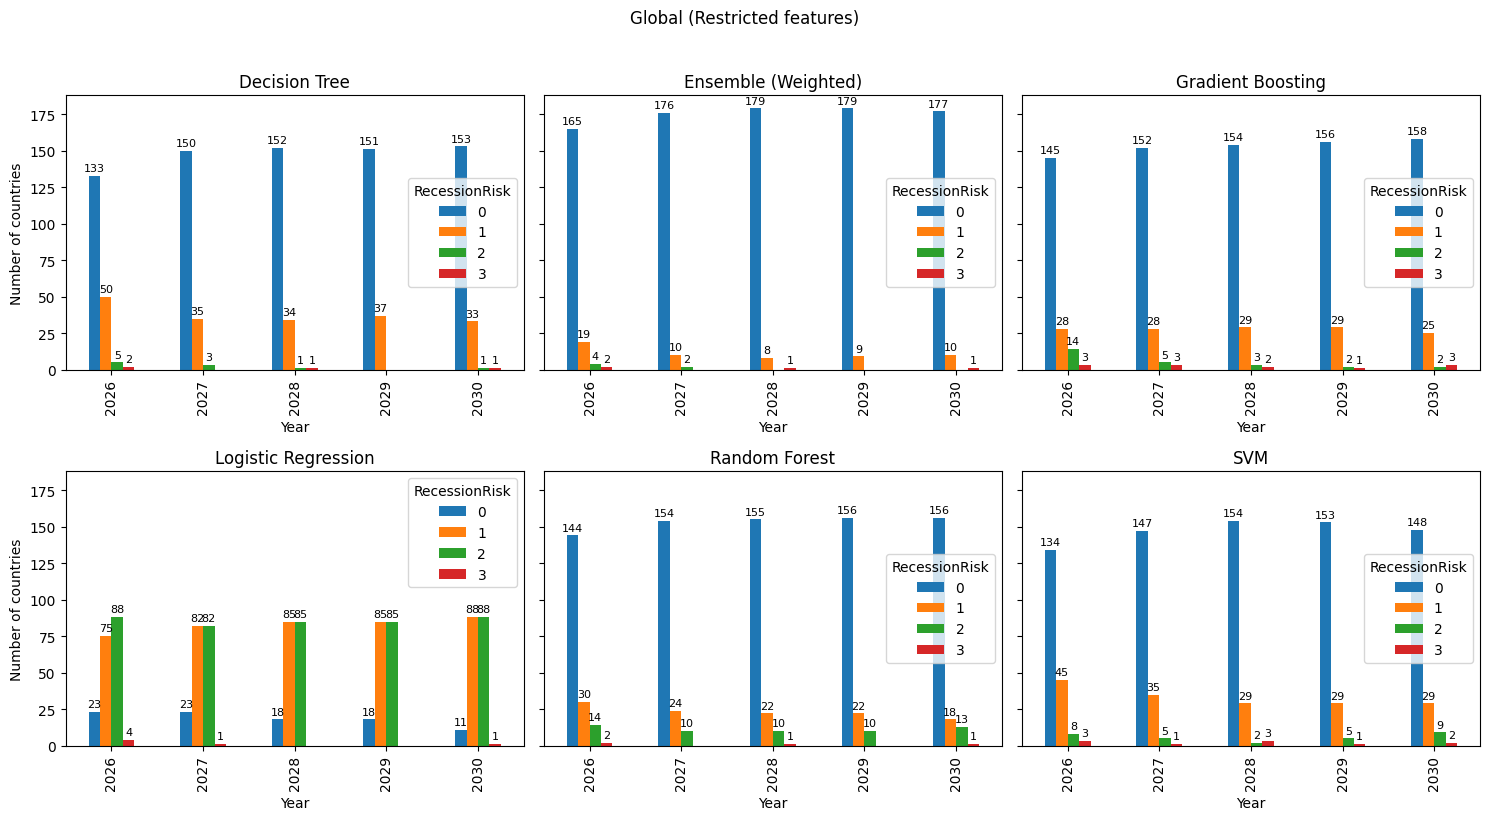

In [120]:
# ============================================================
# Global Restricted (all countries, restricted feature set)
# ============================================================
df_predict_restricted = df_predict[selected_features]
predictions_restricted_features = make_predictions(models_reduced, df_predict_restricted)
predictions_global_restricted_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions_restricted_features.reset_index(drop=True)],
    axis=1
)
print(predictions_global_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_global_restricted_features_with_country, "Global (Restricted features)")

   Year         Country  Logistic Regression  Random Forest  \
0  2026         Albania                    1              0   
1  2026     Switzerland                    1              0   
2  2026  Czech_Republic                    1              0   
3  2026          Cyprus                    1              0   
4  2026          Sweden                    0              0   

   Gradient Boosting  Decision Tree  SVM  Ensemble (Weighted)  
0                  0              0    0                    0  
1                  0              0    1                    0  
2                  0              0    0                    0  
3                  0              2    2                    0  
4                  0              0    0                    0  


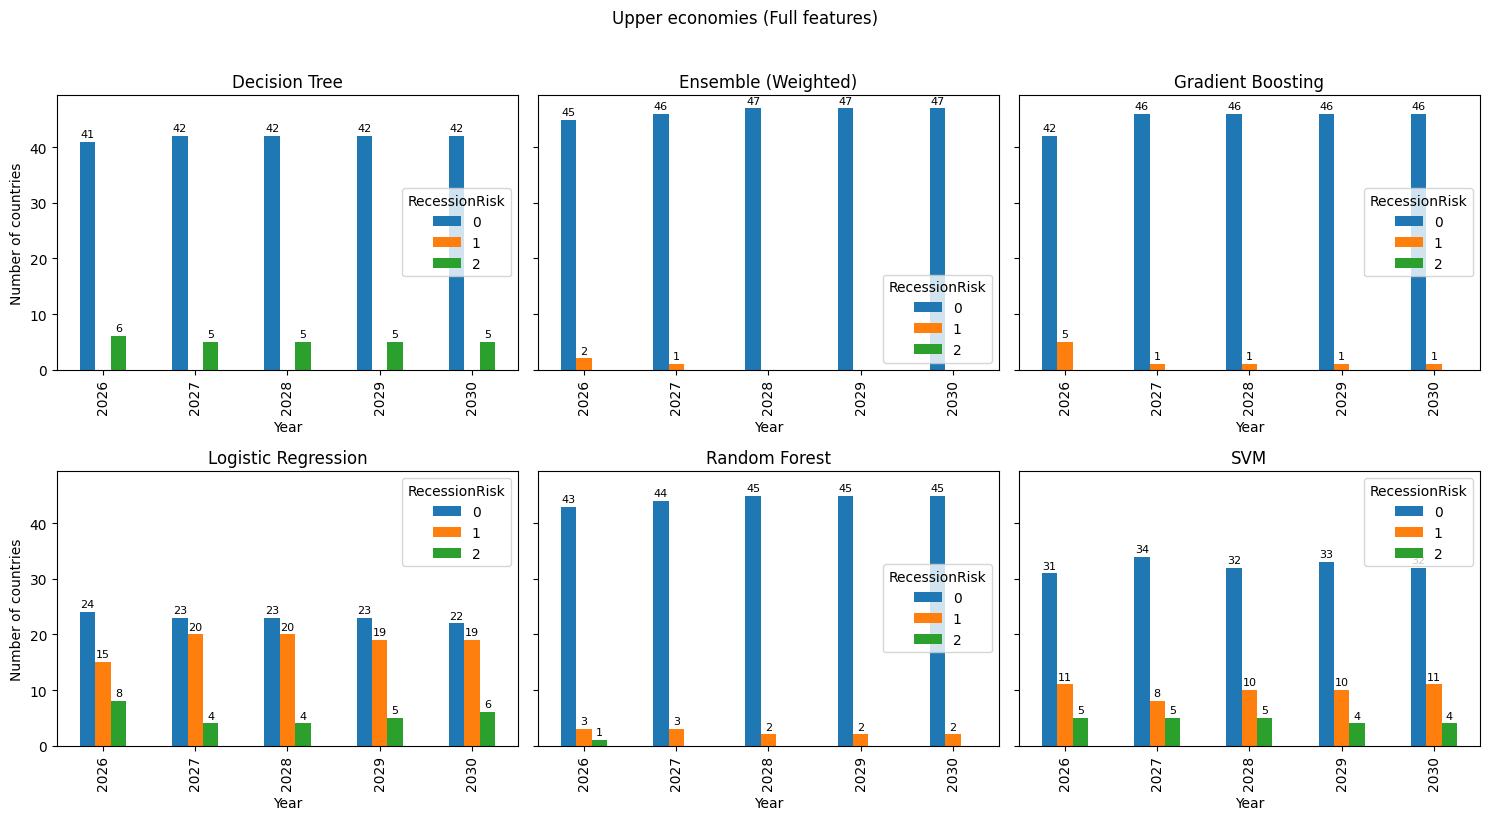

In [121]:

# ============================================================
# Upper Economies (full feature set)
# ============================================================
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper = df_predict_upper_reset.drop(columns=["RecessionRisk", "Country"], errors="ignore")
predictions_upper_features = make_predictions(models_upper, X_predict_upper)

predictions_upper_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_features_with_country, "Upper economies (Full features)")

   Year     Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026     Algeria                    2              0                  0   
1  2026      Zambia                    0              0                  0   
2  2026   Venezuela                    3              3                  3   
3  2026  Mauritania                    1              1                  1   
4  2026    Djibouti                    0              0                  0   

   Decision Tree  SVM  Ensemble (Weighted)  
0              0    3                    0  
1              0    0                    0  
2              3    3                    3  
3              0    1                    0  
4              0    0                    0  


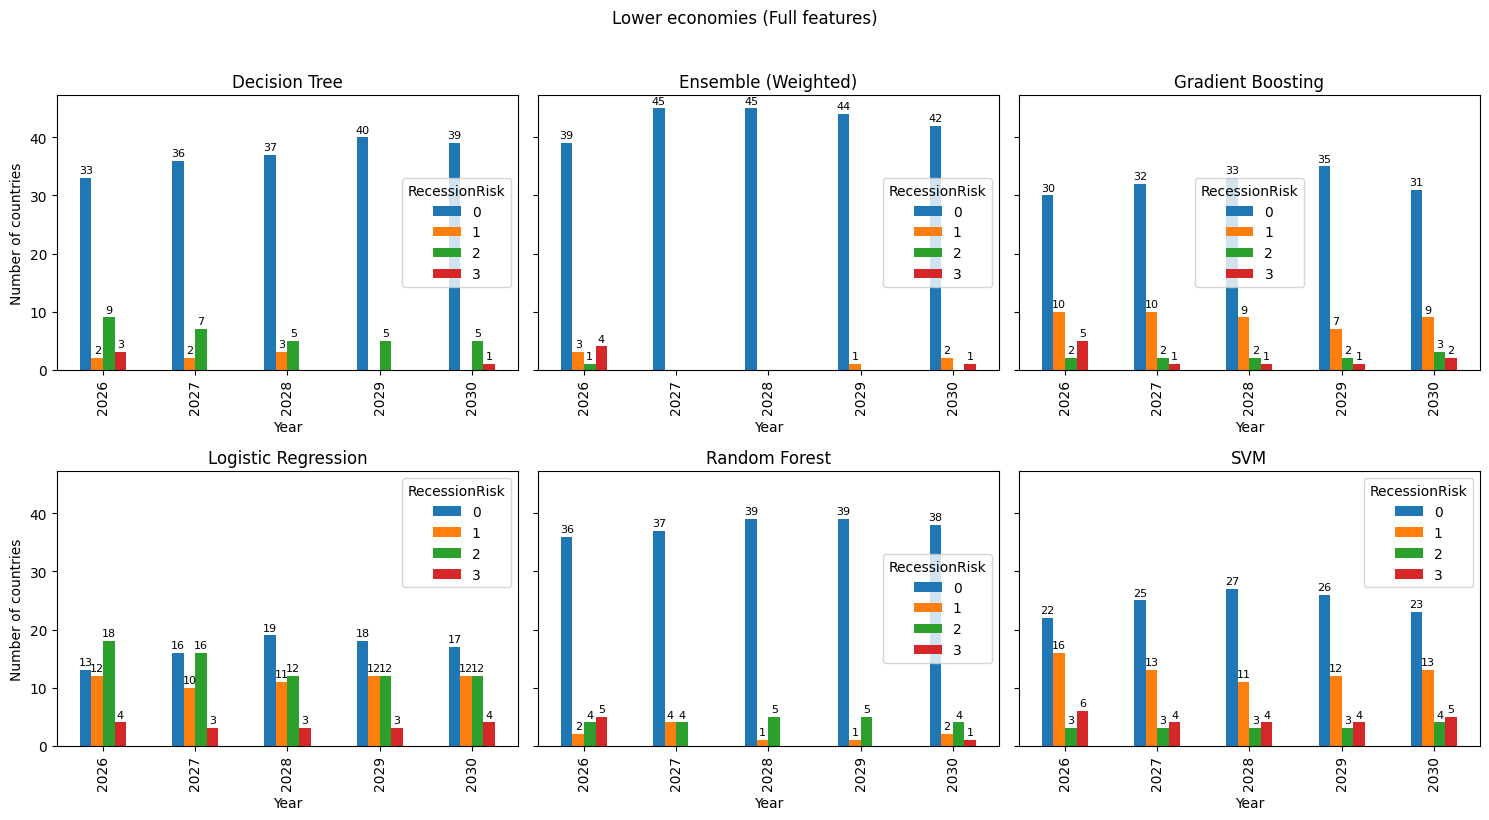

In [122]:
# ============================================================
# Lower Economies (full feature set)
# ============================================================
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)

X_predict_lower = df_predict_lower_reset.drop(columns=["RecessionRisk", "Country"], errors="ignore")
predictions_lower_features = make_predictions(models_lower, X_predict_lower)

predictions_lower_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_features_with_country, "Lower economies (Full features)")

   Year         Country  Logistic Regression  Random Forest  \
0  2026         Albania                    1              0   
1  2026     Switzerland                    0              0   
2  2026  Czech_Republic                    1              0   
3  2026          Cyprus                    2              2   
4  2026          Sweden                    0              0   

   Gradient Boosting  Decision Tree  SVM  Ensemble (Weighted)  
0                  0              0    0                    0  
1                  0              1    0                    0  
2                  0              0    0                    0  
3                  0              1    2                    0  
4                  0              0    0                    0  


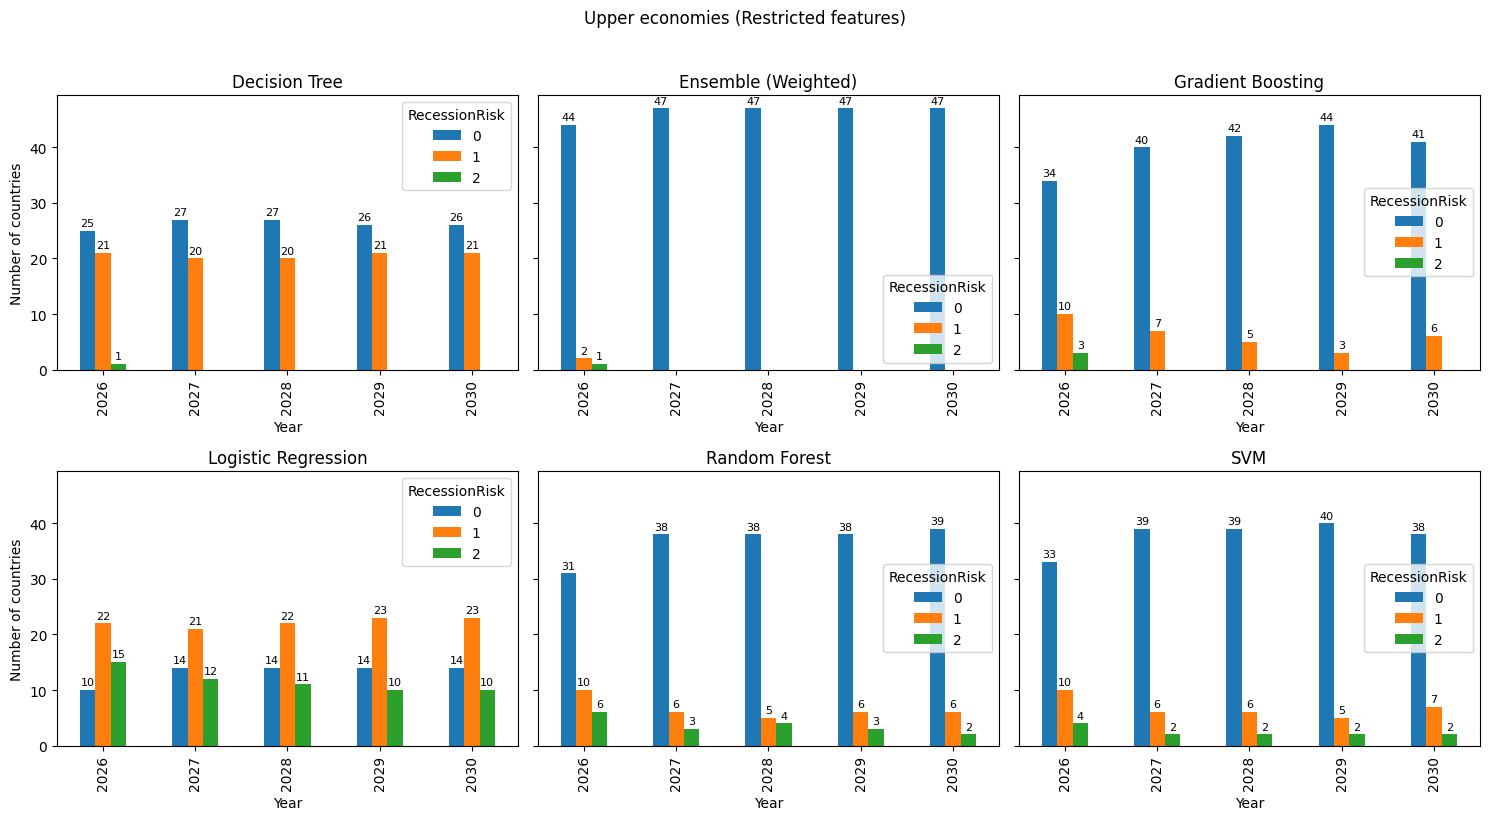

In [123]:
# ============================================================
# Upper Economies (restricted feature set)
# ============================================================
X_predict_upper_reduced = df_predict_upper[selected_features]
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper_reduced = df_predict_upper_reset[selected_features]
predictions_upper_restricted_features = make_predictions(models_upper_reduced, X_predict_upper_reduced)

predictions_upper_restricted_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_restricted_features_with_country, "Upper economies (Restricted features)")

   Year     Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026     Algeria                    2              0                  1   
1  2026      Zambia                    0              0                  0   
2  2026   Venezuela                    3              3                  3   
3  2026  Mauritania                    2              0                  0   
4  2026    Djibouti                    0              0                  0   

   Decision Tree  SVM  Ensemble (Weighted)  
0              0    0                    0  
1              0    0                    0  
2              3    3                    3  
3              0    2                    0  
4              0    0                    0  


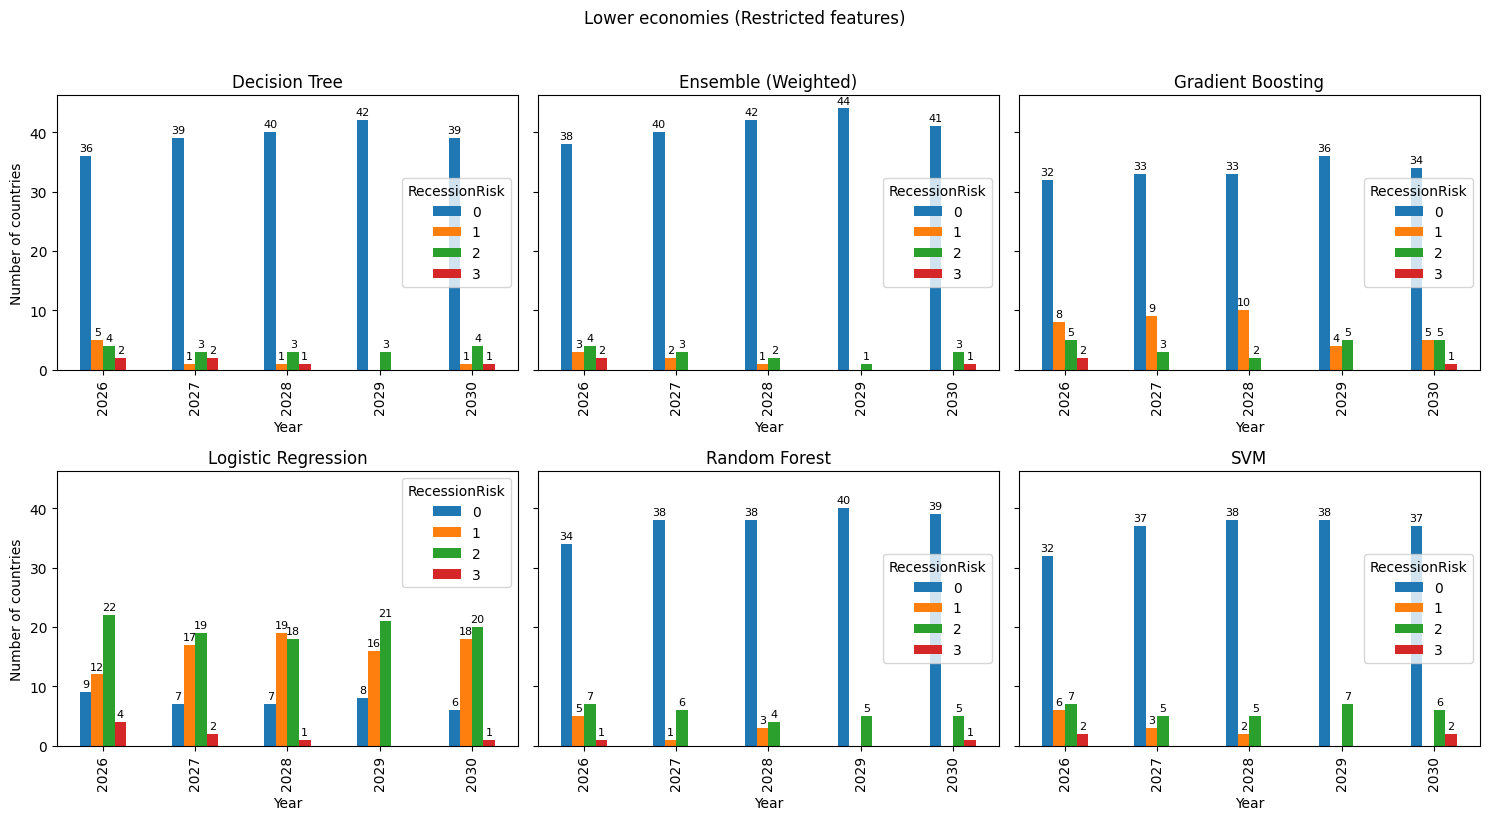

In [124]:
# ============================================================
# Lower Economies (restricted feature set)
# ============================================================
X_predict_lower_reduced = df_predict_lower[selected_features]
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)
X_predict_lower_reduced = df_predict_lower_reset[selected_features]
predictions_lower_restricted_features = make_predictions(models_lower_reduced, X_predict_lower_reduced)

predictions_lower_restricted_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_restricted_features_with_country, "Lower economies (Restricted features)")

# LTSM Neural Networks

In [125]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Core layers
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    GRU,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    Bidirectional
)

# Advanced sequence layers
from tensorflow.keras.layers import (
    Conv1D,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    MultiHeadAttention
)

# Model utilities
from tensorflow.keras.models import Sequential, Model

# Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

# Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop

# Losses & metrics
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


In [126]:
df_until_2025 = df_pivot[df_pivot.index <= 2025]
df_after_2025 = df_pivot[df_pivot.index > 2025]


In [127]:
df_until_2025

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
1980,Philippines,-5.135,28.885018,56.173166,43.869771,31.637437,8.615541,9.258963e+04,5.149,17.114000,23.435000,6.258000e+00,18.201000,3.723000,15.287000,0
1980,Algeria,0.526,28.885018,56.173166,43.869771,31.637437,15.789000,1.509589e+05,-5.400,28.040000,36.058000,8.975000e+00,9.668000,5.047000,-14.588000,2
1980,Albania,0.053,28.885018,56.173166,43.869771,31.637437,5.028000,2.383414e+05,2.684,26.802000,5.349000,1.107572e+11,37.137608,0.000000,0.000000,0
1980,Solomon_Islands,-3.109,24.319000,56.173166,43.869771,20.897000,8.615541,1.717695e+04,-2.663,7.122000,3.650000,4.221000e+00,8.250000,14.100000,3.021000,0
1980,Cyprus,-11.164,28.885018,56.173166,43.869771,31.637437,8.615541,9.448317e+03,5.920,28.651000,49.258000,3.216300e+01,13.518000,4.353000,9.317000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,Tonga,-6.947,41.769000,44.128000,43.869771,49.670000,8.615541,1.099938e+04,2.725,20.686686,24.154875,1.317410e+02,3.570000,5.351302,5.552211,1
2025,Venezuela,-0.067,28.885018,56.173166,43.869771,31.637437,8.615541,2.238718e+06,-4.000,20.686686,24.154875,7.632536e+11,180.001000,-15.518000,-7.966000,2
2025,Cyprus,-7.265,44.195000,60.282000,25.732000,40.357000,4.773000,3.036760e+04,2.545,13.390000,20.655000,1.197320e+02,2.272000,4.660000,4.186000,0


In [128]:
df_after_2025

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,LUR,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,RecessionRisk
Year,,,,,,,,,,,,,,,,
2026,Albania,-3.050,27.898,53.500000,46.714000,30.450,8.800000,822629.982,3.468,22.120000,26.460000,133.147,2.665,3.294000,6.092000,0
2026,Tanzania,-2.866,16.496,45.794000,43.869771,19.277,8.615541,2548922.358,6.294,36.168000,39.033000,461.169,4.011,8.229000,6.487000,0
2026,Algeria,-4.591,24.136,66.950000,64.368000,37.237,8.615541,201264.945,3.004,33.357000,37.948000,302.482,3.646,2.202000,2.912000,0
2026,Tajikistan,-2.083,27.868,28.167000,43.869771,30.369,8.615541,45.838,4.960,22.052000,24.136000,2276.783,5.500,6.210000,7.375000,1
2026,Zambia,2.567,22.575,56.173166,43.869771,26.545,8.615541,8591.965,6.817,34.974000,32.407000,572.131,9.156,5.889000,13.511000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Tajikistan,-2.240,27.489,29.198000,43.869771,29.750,8.615541,51.568,4.500,20.603000,22.843000,2922.129,6.500,0.000000,0.000000,0
2030,Tanzania,-2.477,16.460,40.381000,43.869771,19.135,8.615541,2904355.925,6.196,39.159000,41.636000,539.538,4.001,8.475000,3.836000,0
2030,The_Gambia,-0.561,20.622,44.413000,43.869771,20.980,8.615541,31800.257,5.002,20.780000,21.340000,1210.157,5.000,0.647000,7.557000,0


In [129]:
def reshape_for_lstm(df, window=5, min_sequences=1, return_feature_names=False):
    """
    Convert df_pivot (Year index, Country column) into LSTM-ready sequences.
    
    Args:
        df: DataFrame with Year index and Country column
        window: Number of historical years to use as input
        min_sequences: Minimum sequences required per country (default 1)
        return_feature_names: If True, return feature column names
        
    Returns:
        X_seq: (num_sequences, window, num_features)
        y_seq: (num_sequences,)
        countries_seq: country for each sequence
        years_seq: ending year for each sequence
        feature_names: (optional) list of feature column names
    """
    df = df.copy()
    
    # Handle index - reset if needed for sorting
    if isinstance(df.index, pd.RangeIndex):
        raise ValueError("DataFrame must have Year as index")
    
    # Reset index to make sorting easier, then sort
    df_sorted = df.reset_index().sort_values(["Country", df.index.name])
    year_col = df.index.name or "Year"
    
    # Define features (exclude target and identifiers)
    feature_cols = [c for c in df_sorted.columns 
                   if c not in ["RecessionRisk", "Country", year_col]]
    
    X_seq = []
    y_seq = []
    countries_seq = []
    years_seq = []
    
    # Group by country
    for country, group in df_sorted.groupby("Country"):
        group = group.sort_values(year_col).reset_index(drop=True)
        
        # Check if country has enough data
        if len(group) < window + 1:
            print(f"Warning: {country} has only {len(group)} years, need {window + 1}. Skipping.")
            continue
        
        X_values = group[feature_cols].values
        y_values = group["RecessionRisk"].values
        years = group[year_col].values
        
        # Sliding window
        num_sequences = len(group) - window
        for i in range(num_sequences):
            X_seq.append(X_values[i:i+window])
            y_seq.append(y_values[i+window])
            countries_seq.append(country)
            years_seq.append(years[i+window])
    
    if len(X_seq) < min_sequences:
        raise ValueError(f"Only generated {len(X_seq)} sequences, need at least {min_sequences}")
    
    results = (
        np.array(X_seq),
        np.array(y_seq),
        np.array(countries_seq),
        np.array(years_seq)
    )
    
    if return_feature_names:
        results = results + (feature_cols,)
    
    return results

In [130]:
WINDOW = 5

X_seq, y_seq, countries_seq, years_seq = reshape_for_lstm(
    df_until_2025,
    window=WINDOW
)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)
print("Example sequence shape:", X_seq[0].shape)


X_seq shape: (7287, 5, 14)
y_seq shape: (7287,)
Example sequence shape: (5, 14)


In [131]:
# Option 1: Simple time-based split (most common for time series)
# Train on earlier years, test on most recent years
SPLIT_YEAR = 2019  # Adjust based on your data

train_mask = years_seq <= SPLIT_YEAR
test_mask = years_seq > SPLIT_YEAR

# This gives you:
# Train: all sequences predicting up to 2019
# Test: sequences predicting 2020,2021,2022,2023, 2024, 2025

X_train, X_test = X_seq[train_mask], X_seq[test_mask]
y_train, y_test = y_seq[train_mask], y_seq[test_mask]
countries_train = countries_seq[train_mask]
countries_test  = countries_seq[test_mask]
years_train = years_seq[train_mask]
years_test  = years_seq[test_mask]

print(f"Train sequences: {len(X_train)} (predicting years {years_train.min()}-{years_train.max()})")
print(f"Test sequences: {len(X_test)} (predicting years {years_test.min()}-{years_test.max()})")
print(f"Train: {np.sum(train_mask)} sequences, Test: {np.sum(test_mask)} sequences")
print(f"Split: {np.sum(train_mask)/(np.sum(train_mask)+np.sum(test_mask))*100:.1f}% train, {np.sum(test_mask)/(np.sum(train_mask)+np.sum(test_mask))*100:.1f}% test")

Train sequences: 6128 (predicting years 1985-2019)
Test sequences: 1159 (predicting years 2020-2025)
Train: 6128 sequences, Test: 1159 sequences
Split: 84.1% train, 15.9% test


Data scaled successfully
X_train_scaled shape: (6128, 5, 14)
X_test_scaled shape: (1159, 5, 14)


Unique RecessionRisk classes: [0 1 2 3]

Class distribution in train:
0    2923
1    1517
2     880
3     808
Name: count, dtype: int64

Class distribution in test:
0    487
1    283
2    184
3    205
Name: count, dtype: int64

Number of classes: 4


Building simple LSTM model...


Model: "SimpleLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,436 (87.64 KB)

 Trainable params: 22,436 (87.64 KB)

 Non-trainable params: 0 (0.00 B)



Model compiled successfully


Callbacks configured


Starting training...
Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4577 - loss: 1.2661 - val_accuracy: 0.4262 - val_loss: 1.3193 - learning_rate: 0.0010
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4923 - loss: 1.2043 - val_accuracy: 0.4297 - val_loss: 1.3109 - learning_rate: 0.0010
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4941 - loss: 1.1816 - val_accuracy: 0.4193 - val_loss: 1.3242 - learning_rate: 0.0010
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5011 - loss: 1.1691 - val_accuracy: 0.4211 - val_loss: 1.3287 - learning_rate: 0.0010
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4989 - loss: 1.1627 - val_accuracy: 0.4098 - val_loss: 1.3464 - learning_rate: 0.0010
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5021 - loss: 1.1558 - val_accuracy: 0.4193 - val_loss: 1.3414 - learning_rate: 0.0010
Epoch 

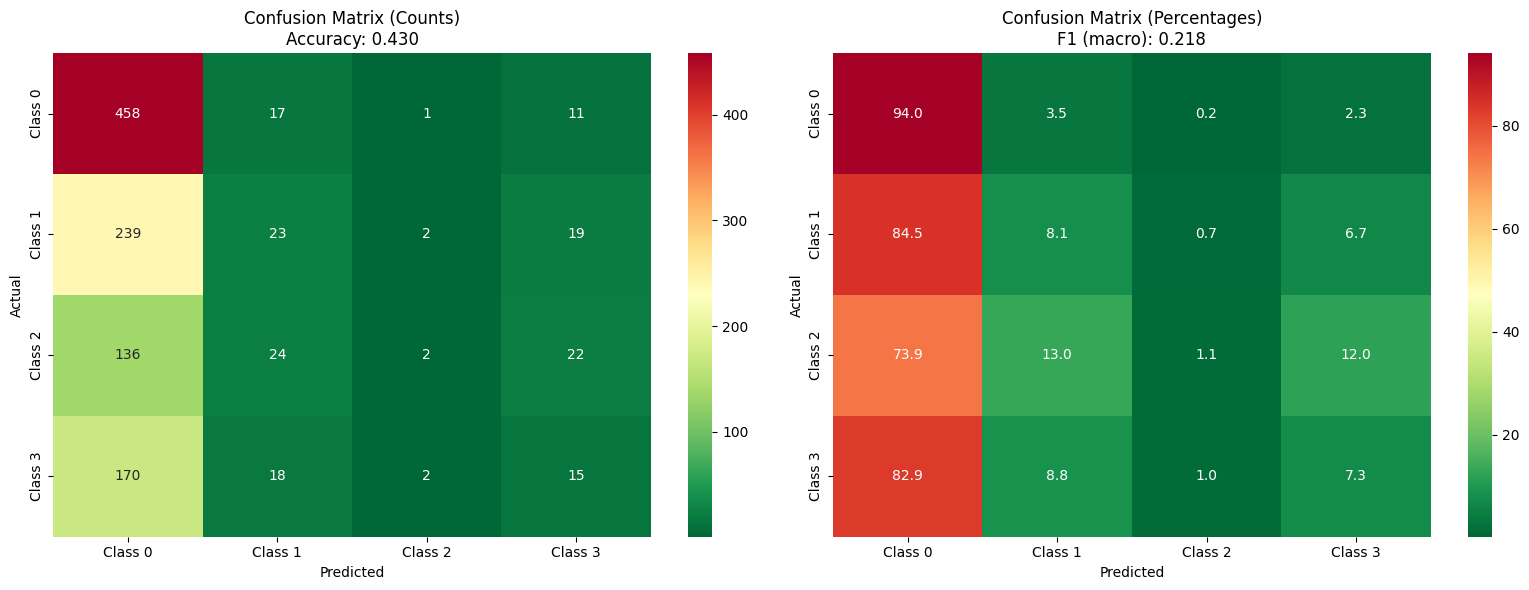

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.46      0.94      0.61       487
     Class 1       0.28      0.08      0.13       283
     Class 2       0.29      0.01      0.02       184
     Class 3       0.22      0.07      0.11       205

    accuracy                           0.43      1159
   macro avg       0.31      0.28      0.22      1159
weighted avg       0.35      0.43      0.31      1159



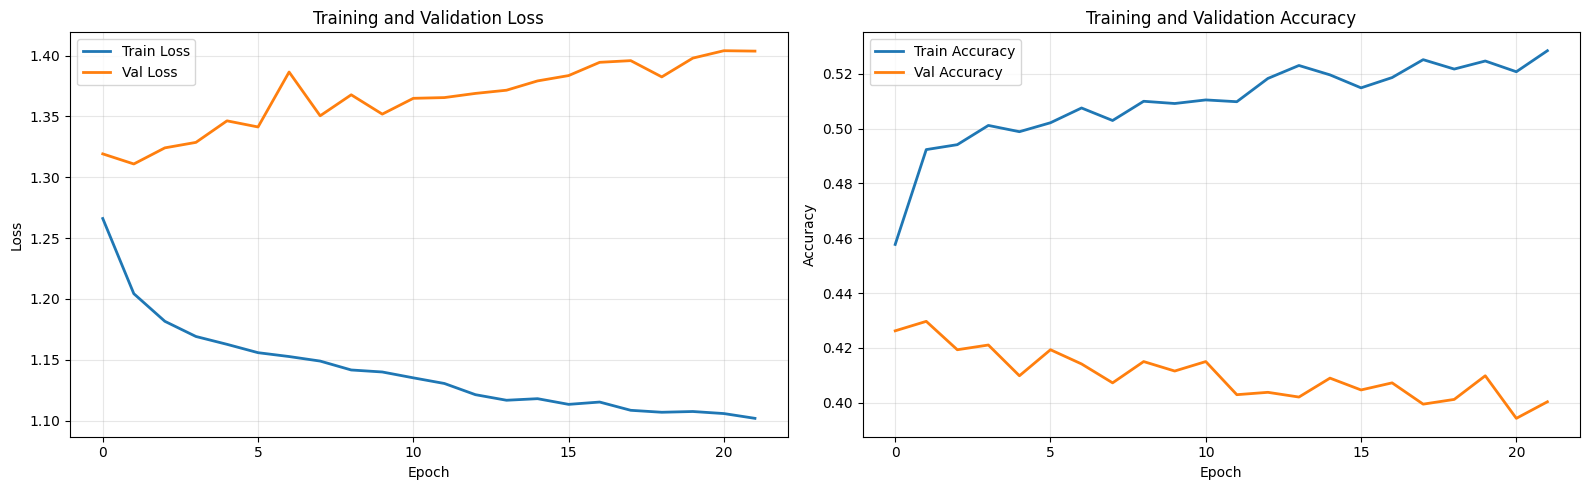


✅ SIMPLE LSTM MODEL TRAINING COMPLETE


In [ ]:
# SIMPLE LSTM MODEL
from sklearn.utils.class_weight import compute_class_weight

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

num_classes = len(np.unique(y_seq))
print(f"Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
print(f"Number of classes: {num_classes}\n")

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}\n")

# Build simple LSTM
model = keras.Sequential([
    keras.layers.LSTM(32, input_shape=(WINDOW, X_train_scaled.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
], name='SimpleLSTM')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_classes = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_classes, average='weighted'):.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - Accuracy: {test_acc:.3f}')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=[f'Class {i}' for i in range(num_classes)],
                          zero_division=0))

# Training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()